In [1]:
import functools

import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, curve_fit, minimize, least_squares
from IPython.display import clear_output
from matplotlib import ticker

from notebooks.utils import *

In [2]:
from datetime import datetime, timezone
from zoneinfo import ZoneInfo

dt_local = datetime(2025, 9, 13, 21, 0, tzinfo=ZoneInfo("Europe/Zurich"))
dt_utc = dt_local.astimezone(timezone.utc)

runs, histories, config_df = load_runs(
    filters={
        # "tags": "crit_bs_l8_d512",
        "$and": [
            # {"$not": {"tags": "flagged"}},
            {"$or": [
                {"tags": "crit_bs_l8_d512"},
                {"tags": "crit_bs_l10_d640"},
                {"tags": "crit_bs_l12_d768"},
                {"tags": "crit_bs_l16_d1024"},
                {"tags": "crit_bs_l20_d1536"},
                {"tags": "scaling_laws"},
            ]},
            {"created_at": {"$gte": dt_utc.isoformat()}}
        ],
    },
    order="+created_at",
    drop_duplicates=["num_layers", "hidden_size", "learning_rate", "batch_size", "hybrid_mixing_shift"],
)

config_df = config_df.reset_index()

# config_df = config_df.sort_values(["total_steps", "final_elbo"], ascending=[False, True])#.drop_duplicates(subset=["num_layers", "hidden_size", "learning_rate", "batch_size", "hybrid_mixing_shift"])
len(config_df)

Processing runs:   0%|          | 0/742 [00:00<?, ?it/s]

Skipping run gidd-L8-D512-H8-N2048-bs=32-lr=0.3-noise_mask with insufficient steps: None
Skipping run gidd-L8-D512-H8-N2048-bs=256-lr=0.5-noise_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=1.0-noise_low_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=1.0-noise_high_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=1.0-noise_balanced with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=0.3-noise_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=0.3-noise_high_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=0.3-noise_balanced with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=1.0-noise_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=1.0-noise_mask with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048

592

In [3]:
def get_noise_label(hybrid_mixing_shift):
    if hybrid_mixing_shift == 0.0:
        return "balanced"
    if hybrid_mixing_shift <= -1e2:
        return "masked"
    if hybrid_mixing_shift >= 1e2:
        return "uniform"
    if hybrid_mixing_shift < 0:
        return "low-uniform"
    if hybrid_mixing_shift > 0:
        return "high-uniform"

colors = {
    -1000.0: (58, 76, 192),
    -2.0: (141, 175, 253),
    0.0: (122, 220, 121),
    2.0: (243, 152, 121),
    1000.0: (179, 3, 38),
}

In [4]:
max_loss = 4.4
min_loss = float(min(h["train/elbo_ema"].min() for h in histories if "train/elbo_ema" in h))

loss_targets = np.logspace(np.log10(min_loss), np.log10(max_loss), 64)[::-1]
flop_targets = np.logspace(np.log10(1e17), np.log10(5e20), 64)

min_loss, max_loss

(2.630140815719817, 4.4)

In [5]:
def f(xs, a=1.0, alpha=0.1, b=1.0, beta=1.0, c=1.0, gamma=1e-4, E=0.0):
    return np.exp(a) * xs[0]**-np.exp(alpha) + np.exp(b) * (xs[1])**-np.exp(beta) + np.exp(c) * xs[2]**-np.exp(gamma) + np.exp(E)

def loss(params, steps, batch_size, popt=None):
    assert popt is not None
    return f((params, steps, batch_size), *popt)

def loss_from_tokens(params, tokens, batch_size=None, steps=None, popt=None):
    assert popt is not None
    assert not (steps is None and batch_size is None)
    if steps is None:
        steps = tokens / batch_size
    if batch_size is None:
        batch_size = tokens / steps
    return f((params, steps, batch_size), *popt)

def loss_from_flops(flops, batch_size, params=None, tokens=None, popt=None):
    assert popt is not None
    assert not (tokens is None and params is None)
    if tokens is None:
        tokens = flops / (6*params)
    if params is None:
        params = flops / (6*tokens)
    steps = tokens / batch_size
    return f((params, steps, batch_size), *popt)

In [6]:
def step_at_smoothed_loss(target_loss, history, min_window=8, min_fraction=0.1, check_bounds=True):
    loss = history["train/elbo"]
    steps = history["_step"]
    delta = (loss - target_loss) / target_loss
    rolling_delta = delta.rolling(window=32, center=True, min_periods=1)
    idx = rolling_delta.mean().abs().idxmin()
    min_idx = max(0, min(idx - min_window, int(idx / (1.0 + min_fraction))))
    max_idx = min(len(steps), max(idx + min_window, int(idx * (1.0 + min_fraction))))
    xs = steps.iloc[min_idx:max_idx]
    ys = loss.iloc[min_idx:max_idx]

    coeff = np.polyfit(np.log(xs), np.log(ys), 1)
    b, a = coeff  # reversed order
    loss_fit = np.exp(a + np.log(xs)*b)
    target_step = np.exp((np.log(target_loss) - a) / b)

    if check_bounds:
        if target_step < xs.min() or target_step > xs.max():
            target_step = np.nan

    return target_step, {
        "closest_step": steps.iloc[idx],
        "closest_loss": loss.iloc[idx],
        "steps": xs,
        "losses": ys,
        "loss_fit": loss_fit,
    }

def smoothed_loss_at_step(target_step, history, min_window=8, min_fraction=0.1, check_bounds=True):
    loss = history["train/elbo"]
    steps = history["_step"].astype(np.float64)
    delta = (steps - target_step) / target_step
    idx = delta.abs().idxmin()
    min_idx = max(0, min(idx - min_window, int(idx / (1.0 + min_fraction))))
    max_idx = min(len(steps), max(idx + min_window, int(idx * (1.0 + min_fraction))))
    xs = steps.iloc[min_idx:max_idx]
    ys = loss.iloc[min_idx:max_idx]

    coeff = np.polyfit(np.log(xs), np.log(ys), 1)
    b, a = coeff  # reversed order
    loss_fit = np.exp(a + np.log(xs)*b)
    target_loss = np.exp(a + np.log(target_step)*b)

    if check_bounds:
        if target_step < xs.min() or target_step > xs.max():
            target_loss = np.nan

    return target_loss, {
        "closest_step": steps.iloc[idx],
        "closest_loss": loss.iloc[idx],
        "steps": xs,
        "losses": ys,
        "loss_fit": loss_fit,
    }

sahqiq96


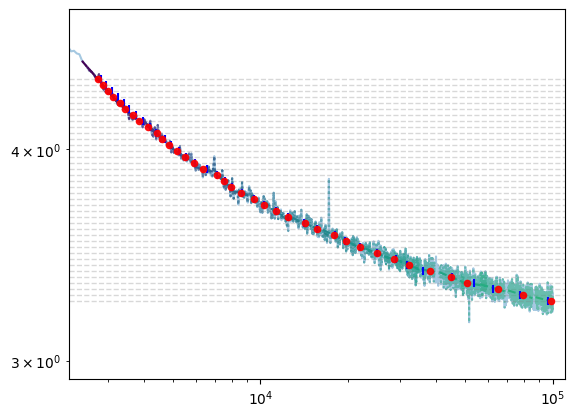

In [7]:
idx = 221

print(runs[idx].id)
h = histories[idx]

vmin, vmax = loss_targets.min(), loss_targets.max()

def color(x):
    cmap = plt.get_cmap("viridis_r")
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    return cmap(norm(x))

steps = h["_step"]
loss = h["train/elbo"]
plt.plot(steps, loss, alpha=0.4, zorder=0)

# targets = loss_targets[:32:2]
targets = loss_targets[::1]

min_step, max_step = 100000, 0
min_loss, max_loss = 1e10, 0
for target_loss in targets:
    target_step, info = step_at_smoothed_loss(target_loss, h)

    # print(target_loss, target_step)
    # print(info)

    if not np.isnan(target_step):
        steps = info["steps"]
        min_step = min(min_step, steps.min())
        max_step = max(max_step, steps.max())
        min_loss = min(min_loss, target_loss)
        max_loss = max(max_loss, target_loss)

        plt.axhline(target_loss, color="gray", linestyle="--", linewidth=1.0, alpha=0.3)
        plt.plot(steps, info["losses"], color=color(target_loss), alpha=0.5, linestyle=":")
        plt.plot(steps, info["loss_fit"], "--", color=color(target_loss))
        plt.scatter(info["closest_step"], target_loss, marker="|", color="blue", zorder=3)
        plt.scatter([target_step], [target_loss], marker="o", color="red", zorder=3, alpha=0.9, s=20)

plt.ylim(0.9 * min_loss, 1.1 * max_loss)
plt.xlim(0.9 * min_step, 1.1 * max_step)
plt.xscale("log")
plt.yscale("log")

d4oru6tb


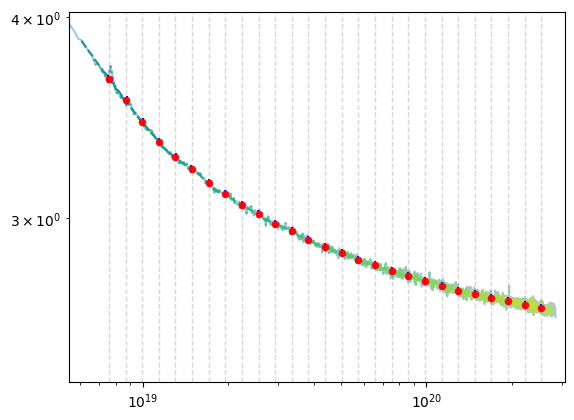

In [8]:
idx = 0

r = runs[idx]
h = histories[idx]
config = config_df.loc[idx]
print(r.id)

vmin, vmax = flop_targets.min(), flop_targets.max()

def color(x):
    cmap = plt.get_cmap("viridis")
    norm = plt.Normalize(vmin=np.log(vmin), vmax=np.log(vmax))
    return cmap(norm(np.log(x)))

steps = h["_step"].to_numpy().astype(np.float64)
flops = 6 * config.non_emb_params * config.max_seq_len * config.batch_size * steps
loss = h["train/elbo"]
plt.plot(flops, loss, alpha=0.4, zorder=0)

# targets = flop_targets[:32:2]
targets = flop_targets[::1]

min_flops, max_flops = 1e100, 0
min_loss, max_loss = 1e10, 0
for target_flops in targets:
    target_step = target_flops / (6 * config.non_emb_params * config.max_seq_len * config.batch_size)
    if target_step < 2000:
        continue
    target_loss, info = smoothed_loss_at_step(target_step, h)

    # print(target_loss, target_step)
    # print(info)

    if not np.isnan(target_loss):
        steps = info["steps"]
        flops = 6 * config.non_emb_params * config.max_seq_len * config.batch_size * steps
        closest_flops = 6 * config.non_emb_params * config.max_seq_len * config.batch_size * info["closest_step"]
        min_flops = min(min_flops, flops.min())
        max_flops = max(max_flops, flops.max())
        min_loss = min(min_loss, target_loss)
        max_loss = max(max_loss, target_loss)

        plt.axvline(target_flops, color="gray", linestyle="--", linewidth=1.0, alpha=0.3)
        plt.plot(flops, info["losses"], color=color(target_flops), alpha=0.5, linestyle=":")
        plt.plot(flops, info["loss_fit"], "--", color=color(target_flops))
        plt.scatter(closest_flops, target_loss, marker="|", color="blue", zorder=3)
        plt.scatter(target_flops, target_loss, marker="o", color="red", zorder=3, alpha=0.9, s=20)

plt.ylim(0.9 * min_loss, 1.1 * max_loss)
plt.xlim(0.9 * min_flops, 1.1 * max_flops)
plt.xscale("log")
plt.yscale("log")

In [9]:
data = []
for row in tqdm.tqdm(config_df.itertuples(), total=len(config_df)):
    h = histories[row.Index]
    steps = h["_step"]
    # flops = 6 * steps * row.non_emb_params
    max_step = steps.max()
    loss = h["train/elbo"]
    for target_flops in flop_targets:
        approx_flops_per_tok = 6 * row.non_emb_params
        approx_target_step = target_flops / (approx_flops_per_tok * row.max_seq_len * row.batch_size)
        approx_tokens = approx_target_step * row.batch_size * row.max_seq_len

        flops_per_tok = 6 * row.non_emb_params + 12 * row.max_seq_len * row.hidden_size * row.num_layers
        target_step = target_flops / (flops_per_tok * row.max_seq_len * row.batch_size)
        tokens = target_step * row.batch_size * row.max_seq_len

        target_loss, approx_target_loss = None, None
        if not np.isnan(target_step) and target_step >= 2000 and target_step <= max_step:
            target_loss, info = smoothed_loss_at_step(target_step, h)
        if not np.isnan(approx_target_step) and approx_target_step >= 2000 and approx_target_step <= max_step:
            approx_target_loss, info = smoothed_loss_at_step(approx_target_step, h)
        if (
            (target_loss is None or np.isnan(target_loss) or not np.isfinite(target_loss))
            and (approx_target_loss is None or np.isnan(approx_target_loss) or not np.isfinite(approx_target_loss))
        ):
            continue

        data.append({
            "index": row.Index,
            "run_id": row.id,
            "target_flops": target_flops,
            "flops_per_tok": flops_per_tok,
            "steps": target_step,
            "tokens": tokens,
            "loss": target_loss,
            "total_flops": flops_per_tok * tokens,
            "approx_flops_per_tok": approx_flops_per_tok,
            "approx_steps": approx_target_step,
            "approx_tokens": approx_tokens,
            "approx_loss": approx_target_loss,
            "approx_total_flops": approx_flops_per_tok * approx_tokens,
            "max_seq_len": row.max_seq_len,
            "hybrid_mixing_shift": row.hybrid_mixing_shift,
            "num_layers": row.num_layers,
            "hidden_size": row.hidden_size,
            "batch_size": row.batch_size,
            "lr": row.lr,
            "beta2": row.beta2,
            "non_emb_params": row.non_emb_params,
            "total_params": row.params,
        })
    # steps = steps_at_loss(row["target_loss"], row)
    # if steps < 5000 or steps > row["total_steps"]:
    #     continue
    # row["steps"] = steps
    # row["tokens"] = steps * row["batch_size"] * row["max_seq_len"]
    # row["flops"] = 6 * row["non_emb_params"] * row["tokens"]

isoflops_df = pd.DataFrame(data)

  0%|          | 0/592 [00:00<?, ?it/s]

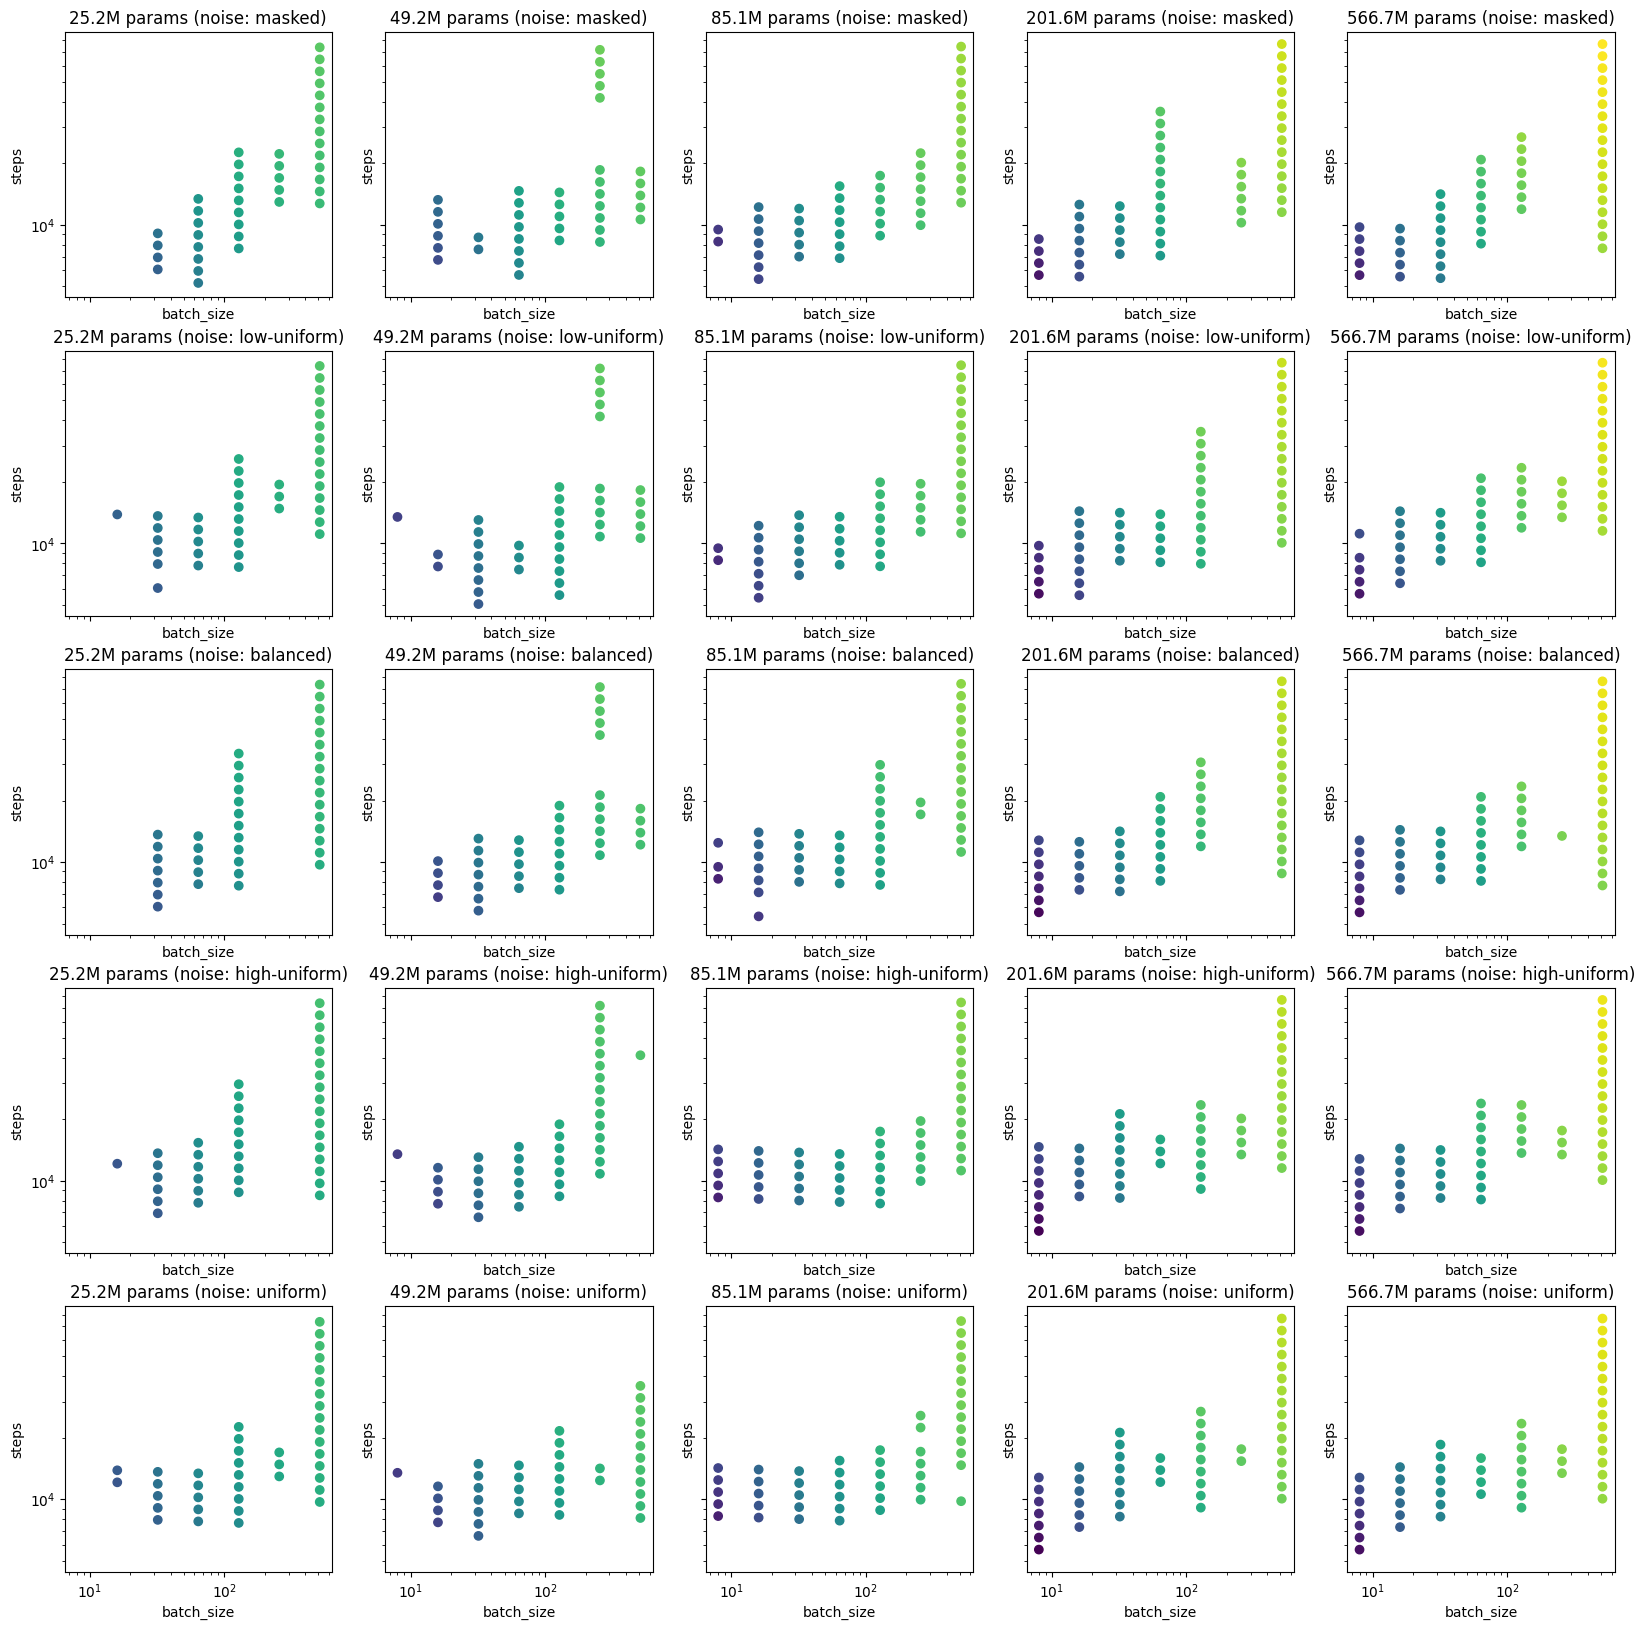

In [ ]:
df_ = isoflops_df.dropna(subset=["loss"])
df_ = df_.loc[df_["batch_size"] < 1024]
df_ = df_.loc[df_.groupby(["hybrid_mixing_shift", "non_emb_params", "target_flops"])["loss"].idxmin()]
# df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "non_emb_params", "tokens"])["loss"].idxmin()]
df_ = df_.loc[(df_["steps"] <= 80000) & (df_["steps"] > 5000)]

fig, axs = plt.subplots(5, len(df_["non_emb_params"].unique()), figsize=(20, 20), sharex=True, sharey=True)

vmin, vmax = df_["loss"].min(), df_["loss"].max()

for i, (params, dfi) in enumerate(df_.groupby("non_emb_params")):
    for j, (hybrid_mixing_shift, dfj) in enumerate(dfi.groupby("hybrid_mixing_shift")):
        ax = axs[j, i]
        ax.scatter(dfj["batch_size"], dfj["steps"], c=dfj["loss"], cmap="viridis_r", vmin=vmin, vmax=vmax)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("batch_size")
        ax.set_ylabel("steps")
        ax.set_title(f"{params/1e6:.1f}M params (noise: {get_noise_label(hybrid_mixing_shift)})")

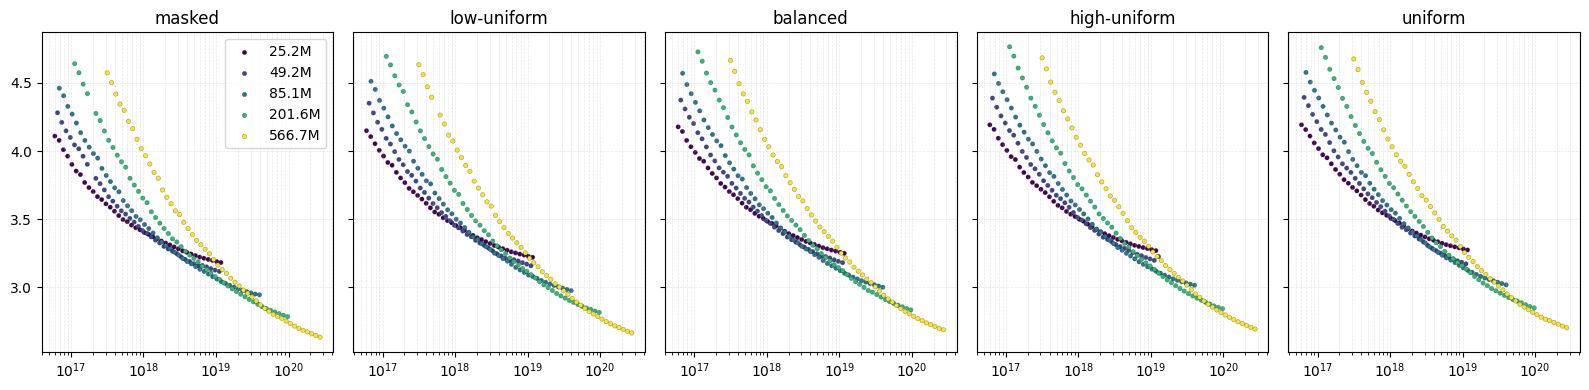

In [13]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), sharey=True)

for i, (hybrid_mixing_shift, dfi) in enumerate(df_.groupby("hybrid_mixing_shift")):
    ax = axs[i]
    ps = dfi["non_emb_params"]
    ts = dfi["tokens"]
    ls = dfi["loss"]

    flops = 6 * ps * ts
    x = flops
    y = ls

    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")

    vmin, vmax = ps.min(), ps.max()
    sc = ax.scatter(x, y, c=np.log(ps), vmin=np.log(vmin), vmax=np.log(vmax), s=10, cmap="viridis", edgecolor=(0,0,0,0.3), linewidth=0.5)
    ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)

    if i == 0:
        for num_params in sorted(ps.unique()):
            ax.scatter([0], [4.4], c=np.log(num_params), vmin=np.log(vmin), vmax=np.log(vmax), s=10, edgecolor=(0,0,0,0.3), linewidth=0.5, label=f"{num_params/1e6:.1f}M")
        ax.legend()

fig.tight_layout()

In [14]:
isoflops_df.to_csv("isoflops.csv", index=False)

In [21]:

data = []
for row in tqdm.tqdm(config_df.itertuples(), total=len(config_df)):
    h = histories[row.Index]
    steps = h["_step"]
    max_step = steps.max()
    loss = h["train/elbo"]
    for target_loss in loss_targets:
        target_step, info = step_at_smoothed_loss(target_loss, h)
        if np.isnan(target_step) or not np.isfinite(target_step):
            continue
        if np.isnan(target_step) or target_step < 2000 or target_step > max_step:
            # print("Warning: target step out of range", row.Index, target_step, max_step)
            continue
        
        # row["target_loss"]
        # row["steps"] = target_step
        # row["tokens"] = target_step * row["batch_size"] * row["max_seq_len"]
        # row["flops"] = 6 * row["non_emb_params"] * row["tokens"]

        # print("appending row")

        tokens = target_step * row.batch_size * row.max_seq_len

        data.append({
            "index": row.Index,
            "target_loss": target_loss,
            "steps": target_step,
            "tokens": tokens,
            "non_emb_flops_per_tok": 6 * row.non_emb_params,
            "total_flops_per_tok": total_flops_per_tok,
            "non_emb_flops": 6 * row.non_emb_params * tokens,
            "total_flops": total_flops_per_tok * tokens,
            "max_seq_len": row.max_seq_len,
            "hybrid_mixing_shift": row.hybrid_mixing_shift,
            "num_layers": row.num_layers,
            "hidden_size": row.hidden_size,
            "batch_size": row.batch_size,
            "lr": row.lr,
            "beta2": row.beta2,
            "non_emb_params": row.non_emb_params,
            "total_params": row.params,
        })
    # steps = steps_at_loss(row["target_loss"], row)
    # if steps < 5000 or steps > row["total_steps"]:
    #     continue
    # row["steps"] = steps
    # row["tokens"] = steps * row["batch_size"] * row["max_seq_len"]
    # row["flops"] = 6 * row["non_emb_params"] * row["tokens"]

loss_df = pd.DataFrame(data)

  0%|          | 0/593 [00:00<?, ?it/s]

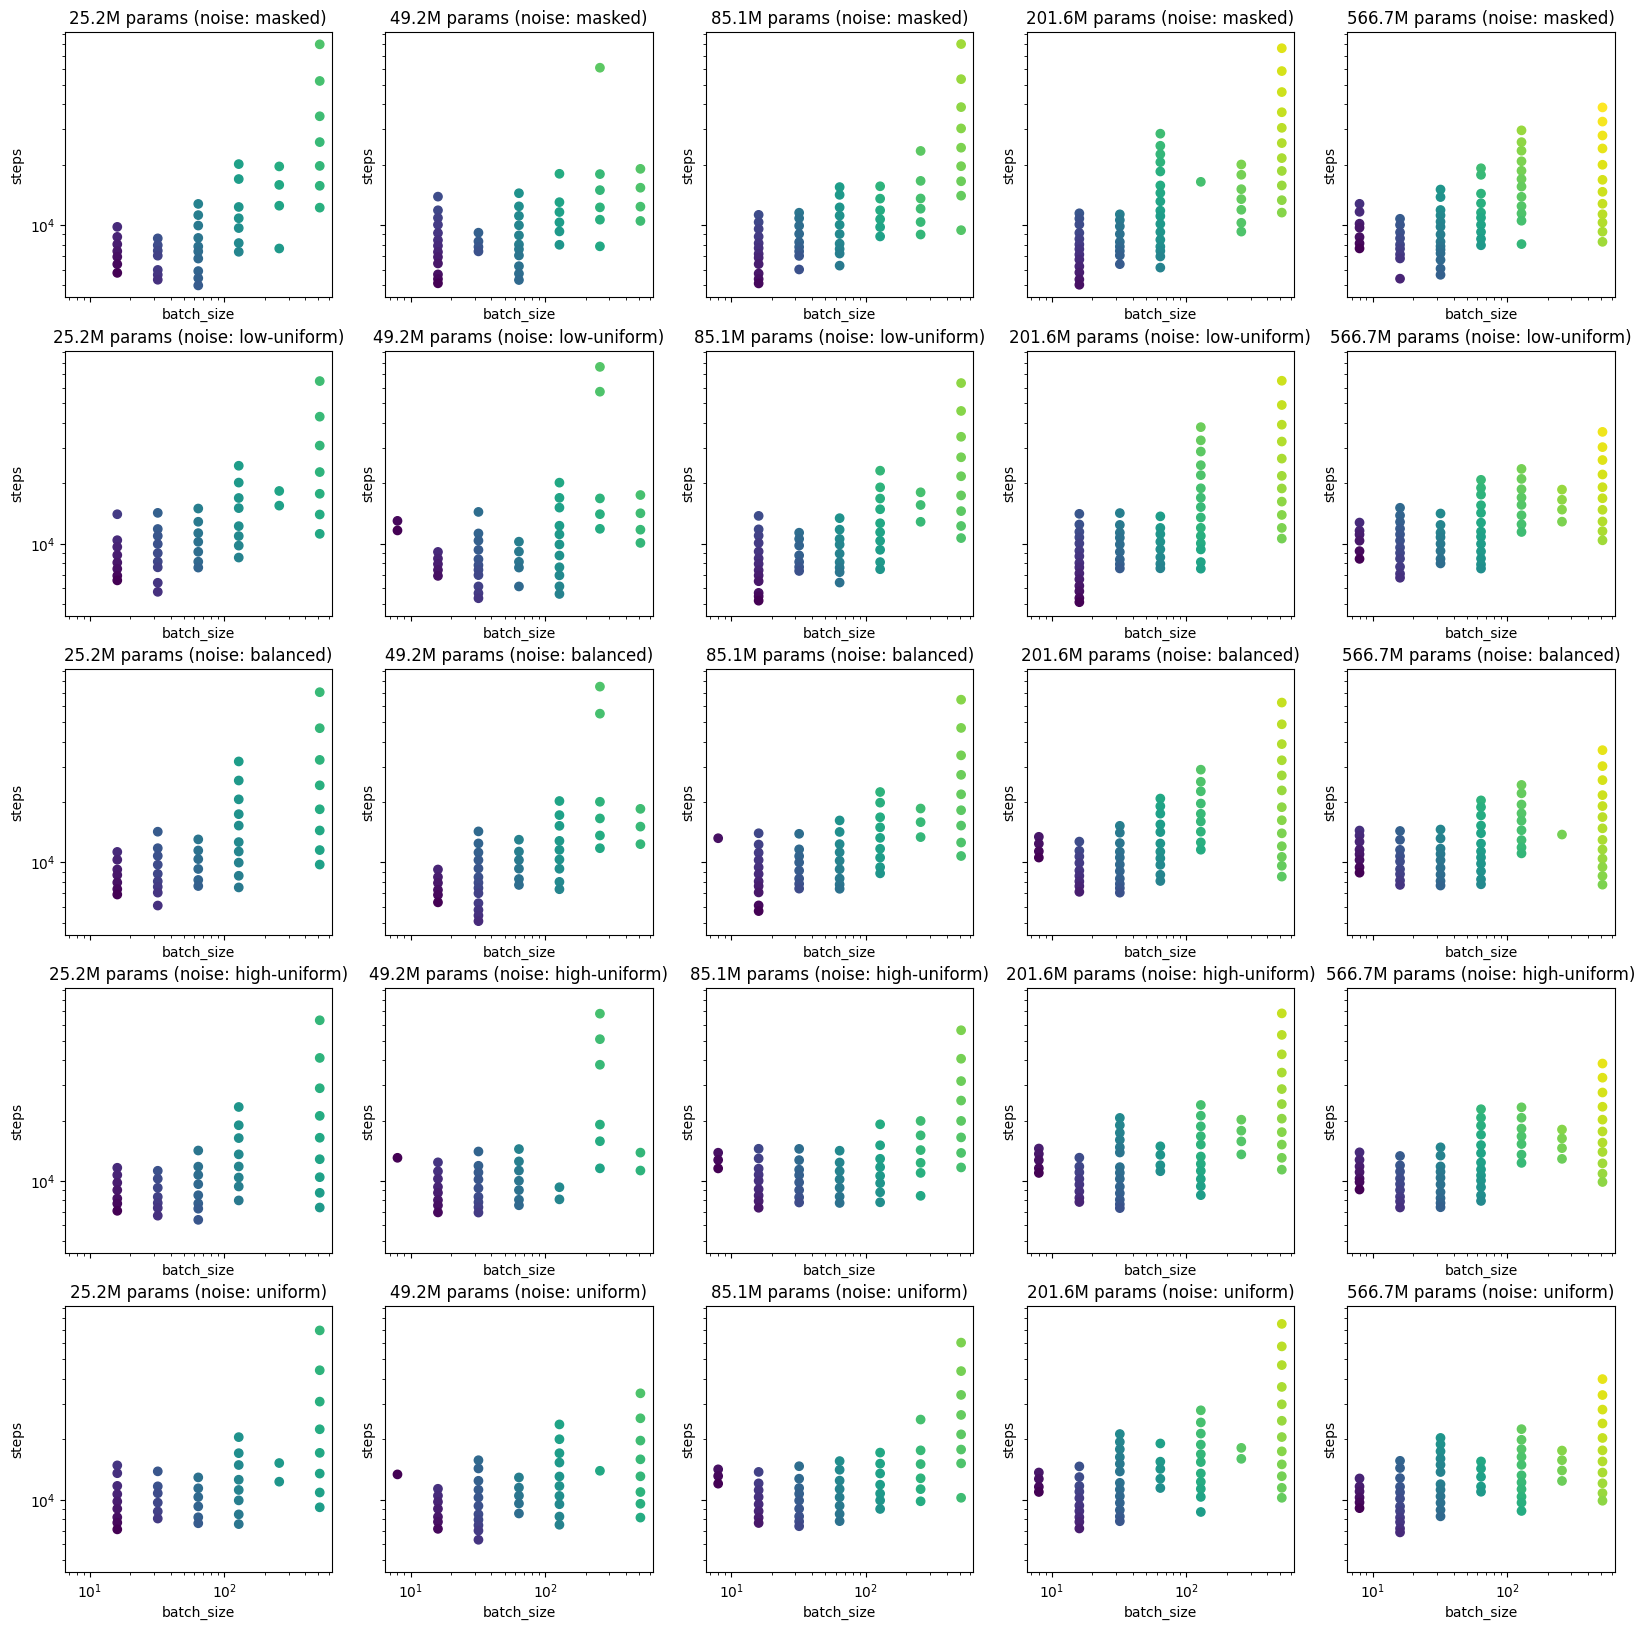

In [15]:
df_ = loss_df
df_ = df_.loc[df_["batch_size"] < 1024]
df_ = df_.loc[df_.groupby(["hybrid_mixing_shift", "non_emb_params", "target_loss"])["tokens"].idxmin()]
# df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "non_emb_params", "tokens"])["target_loss"].idxmin()]
df_ = df_.loc[(df_["steps"] <= 80000) & (df_["steps"] > 5000)]

def sigmoid(x):
    return 1 / (1 + np.exp(-x.clip(-10, 10)))

fig, axs = plt.subplots(5, len(df_["non_emb_params"].unique()), figsize=(20, 20), sharex=True, sharey=True)

vmin, vmax = df_["target_loss"].min(), df_["target_loss"].max()

for i, (params, dfi) in enumerate(df_.groupby("non_emb_params")):
    for j, (hybrid_mixing_shift, dfj) in enumerate(dfi.groupby("hybrid_mixing_shift")):
        ax = axs[j, i]
        # ax.scatter(dfj["batch_size"], dfj["steps"], c=sigmoid(dfj["hybrid_mixing_shift"]))
        ax.scatter(dfj["batch_size"], dfj["steps"], c=dfj["target_loss"], cmap="viridis_r", vmin=vmin, vmax=vmax)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("batch_size")
        ax.set_ylabel("steps")
        ax.set_title(f"{params/1e6:.1f}M params (noise: {get_noise_label(hybrid_mixing_shift)})")

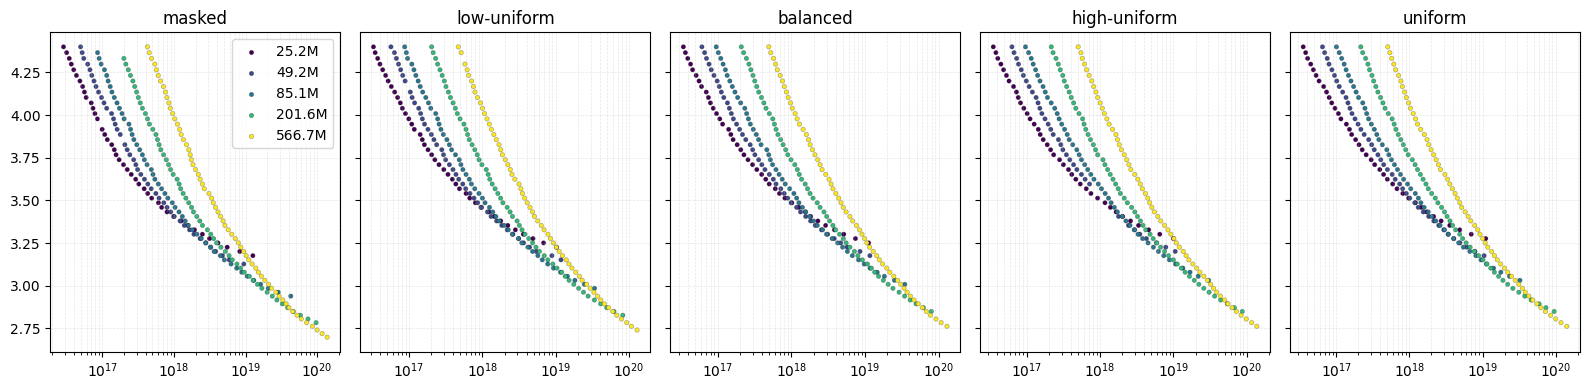

In [17]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), sharey=True)

for i, (hybrid_mixing_shift, dfi) in enumerate(df_.groupby("hybrid_mixing_shift")):
    ax = axs[i]
    ps = dfi["non_emb_params"]
    ts = dfi["tokens"]
    ls = dfi["target_loss"]

    flops = 6 * ps * ts
    x = flops
    y = ls

    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")

    vmin, vmax = ps.min(), ps.max()
    sc = ax.scatter(x, y, c=np.log(ps), vmin=np.log(vmin), vmax=np.log(vmax), s=10, cmap="viridis", edgecolor=(0,0,0,0.3), linewidth=0.5)
    ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)

    if i == 0:
        for num_params in sorted(ps.unique()):
            ax.scatter([0], [4.4], c=np.log(num_params), vmin=np.log(vmin), vmax=np.log(vmax), s=10, edgecolor=(0,0,0,0.3), linewidth=0.5, label=f"{num_params/1e6:.1f}M")
        ax.legend()

fig.tight_layout()

In [22]:
loss_df.to_csv("isoloss.csv", index=False)

In [274]:
scaling_laws = {}
fit_in_logspace = True


def hypothesis1(P, D, a, alpha, b, beta, E):
    return E + a * P**-alpha + b * D**-beta

for i, (hybrid_mixing_shift, dfi) in enumerate(df_.groupby("hybrid_mixing_shift")):
    P1, D1, L1 = dfi["non_emb_params"].values, dfi["tokens"].values, dfi["target_loss"].values

    transform = lambda x: x
    if fit_in_logspace:
        transform = np.log

    def base_resid(f, y, p):
        return transform(f(*p)) - transform(y)

    resid1 = functools.partial(base_resid, functools.partial(hypothesis1, P1, D1), L1)
    
    p1_0 = (1.0,) * 5

    sol1 = least_squares(resid1, p1_0, bounds=(1e-8, np.inf), loss="huber")

    print(f"{get_noise_label(hybrid_mixing_shift):20s}: a={sol1.x[0]:.3g},\talpha={sol1.x[1]:.3g},\tb={sol1.x[2]:.3g},\tbeta={sol1.x[3]:.3g},\tE={sol1.x[4]:.3g}")

    scaling_laws[hybrid_mixing_shift] = {
        "func": hypothesis1,
        "resid": resid1,
        "args": (P1, D1),
        "y": L1,
        "p": sol1.x,
    }


masked              : a=33.6,	alpha=0.23,	b=691,	beta=0.316,	E=2.16
low-uniform         : a=28.8,	alpha=0.218,	b=559,	beta=0.303,	E=2.12
balanced            : a=30.3,	alpha=0.221,	b=471,	beta=0.293,	E=2.12
high-uniform        : a=18.8,	alpha=0.185,	b=444,	beta=0.29,	E=2.02
uniform             : a=16.1,	alpha=0.17,	b=401,	beta=0.284,	E=1.94


masked: $L^*(C) = 10^{2.374} \cdot C^{-0.133} + 2.159$
low-uniform: $L^*(C) = 10^{2.292} \cdot C^{-0.1267} + 2.123$
balanced: $L^*(C) = 10^{2.289} \cdot C^{-0.1259} + 2.123$
high-uniform: $L^*(C) = 10^{2.098} \cdot C^{-0.1128} + 2.024$
uniform: $L^*(C) = 10^{2.018} \cdot C^{-0.1065} + 1.940$


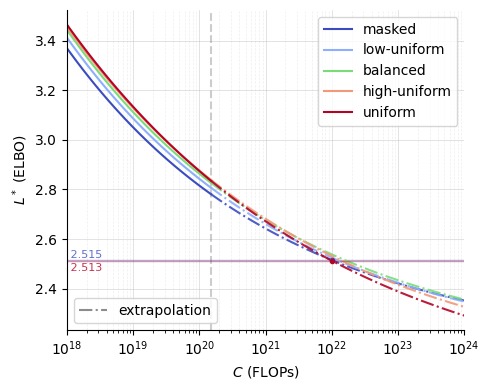

In [277]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

intra_flops = np.logspace(18, np.log10(1.5e20), 50)
extra_flops = np.logspace(np.log10(1.5e20), 24, 50)
flops = np.logspace(18, 24, 100)

idx = np.argmin(np.abs(flops - 1.5e20))

ax.axvline(x=1.5e20, color="gray", linestyle="--", alpha=0.4)
ax.plot([], [], linestyle="-.", color="gray", alpha=0.9, label="extrapolation")

for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    color = colors[hybrid_mixing_shift]

    a, alpha, b, beta, E = scaling_law["p"]
    C_star_a = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))
    C_star_alpha = (-(alpha*beta)/(alpha + beta))

    L_star_C_intra = E + C_star_a * (intra_flops/6)**C_star_alpha
    L_star_C_extra = E + C_star_a * (extra_flops/6)**C_star_alpha


    if hybrid_mixing_shift == -1000.0:
        C = 1e22
        L = E + C_star_a * (C/6)**C_star_alpha
        ax.plot([C], [L], ".", color=np.array(color)/255.0, zorder=10)
        ax.axhline(y=L, color=np.array(color)/255.0, linestyle="-", alpha=0.4, linewidth=1.0)
        ax.text(1e18, L, f" {L:.3f}", fontsize=8, va="bottom", ha="left", color=np.array(color)/255.0, alpha=0.8)

    
    if hybrid_mixing_shift == 1000.0:
        C = 1e22
        L = E + C_star_a * (C/6)**C_star_alpha
        ax.plot([C], [L], ".", color=np.array(color)/255.0, zorder=10)
        ax.axhline(y=L, color=np.array(color)/255.0, linestyle="-", alpha=0.4, linewidth=1.0)
        ax.text(1e18, L*0.996, f" {L:.3f}", fontsize=8, va="top", ha="left", color=np.array(color)/255.0, alpha=0.8)

    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(intra_flops, L_star_C_intra, linestyle="-", color=np.array(color)/255.0, label=label)
    ax.plot(extra_flops, L_star_C_extra, linestyle="-.", color=np.array(color)/255.0, alpha=0.9)

    print(get_noise_label(hybrid_mixing_shift) + ": $L^*(C) = 10^{{{:.4g}}} \\cdot C^{{{:.4g}}} + {:.3f}$".format(np.log10(C_star_a), C_star_alpha, E))


handles, labels = ax.get_legend_handles_labels()
trend_mask = [lbl.startswith("extrapolation") for lbl in labels]
trend_handles = [h for h, m in zip(handles, trend_mask) if m]
trend_labels = [l for l, m in zip(labels, trend_mask) if m]
main_handles = [h for h, m in zip(handles, trend_mask) if not m]
main_labels = [l for l, m in zip(labels, trend_mask) if not m]

leg_main = ax.legend(main_handles, main_labels, loc="upper right")
ax.add_artist(leg_main)
ax.legend(trend_handles, trend_labels, loc="lower left")

ax.set_xscale("log")
# ax.set_yscale("log")
# ax.legend()

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlim(1e18, 1e24)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel("$C$ (FLOPs)")
ax.set_ylabel("$L^*$ (ELBO)")
fig.tight_layout()
fig.savefig("plots/compute_optimal_frontier.pdf", bbox_inches="tight")

masked: P^* \propto C^{0.579}, D^* \propto C^{0.421}
low-uniform: P^* \propto C^{0.582}, D^* \propto C^{0.418}
balanced: P^* \propto C^{0.571}, D^* \propto C^{0.429}
high-uniform: P^* \propto C^{0.611}, D^* \propto C^{0.389}
uniform: P^* \propto C^{0.625}, D^* \propto C^{0.375}


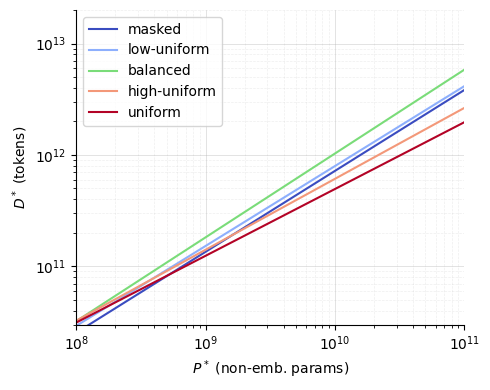

In [278]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    color = colors[hybrid_mixing_shift]

    a, alpha, b, beta, E = scaling_law["p"]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    flops = np.logspace(18, 26, 100)
    params = P_star_a * (flops/6)**P_star_alpha
    tokens = D_star_a * (flops/6)**D_star_alpha

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(params, tokens, color=np.array(color)/255.0, label=label)


    print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e8, 1e11)
ax.set_ylim(3e10, 2e13)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlabel("$P^*$ (non-emb. params)")
ax.set_ylabel("$D^*$ (tokens)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
ax.legend()
fig.tight_layout()
fig.savefig("plots/opt_params_tokens.pdf", bbox_inches="tight")

masked: P^* \propto C^{0.579}, D^* \propto C^{0.421}
low-uniform: P^* \propto C^{0.582}, D^* \propto C^{0.418}
balanced: P^* \propto C^{0.571}, D^* \propto C^{0.429}
high-uniform: P^* \propto C^{0.611}, D^* \propto C^{0.389}
uniform: P^* \propto C^{0.625}, D^* \propto C^{0.375}


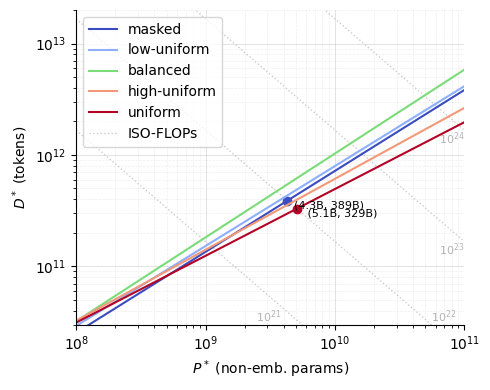

In [280]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

trained_flops = 1e22

for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    color = colors[hybrid_mixing_shift]


    a, alpha, b, beta, E = scaling_law["p"]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    flops = np.logspace(18, 26, 100)
    params = P_star_a * (flops/6)**P_star_alpha
    tokens = D_star_a * (flops/6)**D_star_alpha

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(params, tokens, color=np.array(color)/255.0, label=label)
    
    if hybrid_mixing_shift == -1000.0:
        P = P_star_a * (trained_flops/6)**P_star_alpha
        D = D_star_a * (trained_flops/6)**D_star_alpha
        ax.plot([P], [D], "o", color=np.array(color)/255.0)
        ax.text(P, D, f"  ({P/1e9:.1f}B, {D/1e9:.0f}B)", fontsize=8, va="top", ha="left")
        P_target_mask = P
        D_target_mask = D

    
    if hybrid_mixing_shift == 1000.0:
        P = P_star_a * (trained_flops/6)**P_star_alpha
        D = D_star_a * (trained_flops/6)**D_star_alpha
        ax.plot([P], [D], "o", color=np.array(color)/255.0)
        ax.text(P, D, f"   ({P/1e9:.1f}B, {D/1e9:.0f}B)", fontsize=8, va="top", ha="left")
        P_target_uniform = P
        D_target_uniform = D

    print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e8, 1e11)
ax.set_ylim(3e10, 2e13)

iso_flop_values = [1e21, 1e22, 1e23, 1e24]
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
x_line = np.logspace(np.log10(x_min), np.log10(x_max), 200)
for i, C in enumerate(iso_flop_values):
    y_line = (C/6.0) / x_line
    label = "ISO-FLOPs" if i == 0 else None
    ax.plot(x_line, y_line, linestyle=":", color="gray", alpha=0.4, linewidth=1.0, zorder=0, label=label)
    x_label = x_max
    y_label = (C/6.0)/x_label
    ha = "right"
    va = "top"
    if y_label < y_min:
        va = "bottom"
        y_label = y_min
        x_label = (C/6.0)/y_label
        if C == 1e21:
            ha = "right"
            x_label = x_label * 0.7
        else:
            ha = "left"
    # if not (y_min < y_label < y_max):
    #     x_label = x_min*1.5
    #     y_label = (C/6.0)/x_label
    ax.text(x_label, y_label, f"$10^{{{int(np.log10(C))}}}$", fontsize=8, va=va, ha=ha, color="gray", alpha=0.6)

# iso_flop_values = [1e22]
# for i, C in enumerate(iso_flop_values):
#     y_line = (C/6.0) / x_line
#     label = None
#     ax.plot(x_line, y_line, linestyle=":", color="gray", alpha=0.8, linewidth=1.0, zorder=0, label=label)

#     ha = "right"
#     va = "bottom"
#     y_label = y_min
#     x_label = (C/6.0)/y_label * 0.73
#     # if not (y_min < y_label < y_max):
#     #     x_label = x_min*1.5
#     #     y_label = (C/6.0)/x_label
#     ax.text(x_label, y_label, "$5 \\times 10^{21}$", fontsize=8, va=va, ha=ha, color="gray", alpha=0.9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlabel("$P^*$ (non-emb. params)")
ax.set_ylabel("$D^*$ (tokens)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
ax.legend(loc="upper left")
fig.tight_layout()
fig.savefig("plots/opt_params_tokens.pdf", bbox_inches="tight")


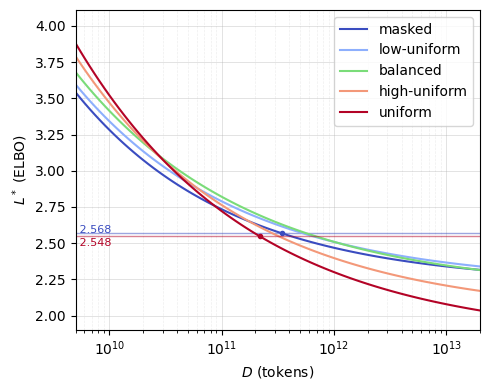

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

tokens = np.logspace(np.log10(1e9), np.log10(2e13), 100)

for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    color = colors[hybrid_mixing_shift]

    a, alpha, b, beta, E = scaling_law["p"]
    # P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    # D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    # flops = 6 * tokens * params
    # params = P_star_a * (flops/6)**P_star_alpha
    # tokens = D_star_a * (flops/6)**D_star_alpha
    L_star = E + ((alpha+beta)/alpha)*b * tokens**(-beta)

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(tokens, L_star, color=np.array(color)/255.0, label=label)

    if hybrid_mixing_shift == -1000.0:
        D = D_target_mask
        L = E + ((alpha+beta)/alpha)*b * D**(-beta)
        ax.plot([D], [L], ".", color=np.array(color)/255.0)
        ax.axhline(y=L, color=np.array(color)/255.0, linestyle="-", alpha=0.5, linewidth=1.0)
        # ax.text(5e9, L, f" {L:.3f}", fontsize=8, va="bottom", ha="left")
        ax.text(5e9, L*0.995, f" {L:.3f}", fontsize=8, va="bottom", ha="left", color=np.array(color)/255.0)

    
    if hybrid_mixing_shift == 1000.0:
        D = D_target_uniform
        L = E + ((alpha+beta)/alpha)*b * D**(-beta)
        ax.plot([D], [L], ".", color=np.array(color)/255.0)
        ax.axhline(y=L, color=np.array(color)/255.0, linestyle="-", alpha=0.5, linewidth=1.0)
        # ax.text(5e9, L, f" {L:.3f}", fontsize=8, va="top", ha="left")
        ax.text(5e9, L*0.995, f" {L:.3f}", fontsize=8, va="top", ha="left", color=np.array(color)/255.0)


    # print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")

ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlim(5e9, 2e13)
ax.set_ylim(1.9, 4.11)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlabel("$D$ (tokens)")
ax.set_ylabel("$L^*$ (ELBO)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
ax.legend()
fig.tight_layout()
fig.savefig("plots/opt_loss_vs_tokens.pdf", bbox_inches="tight")

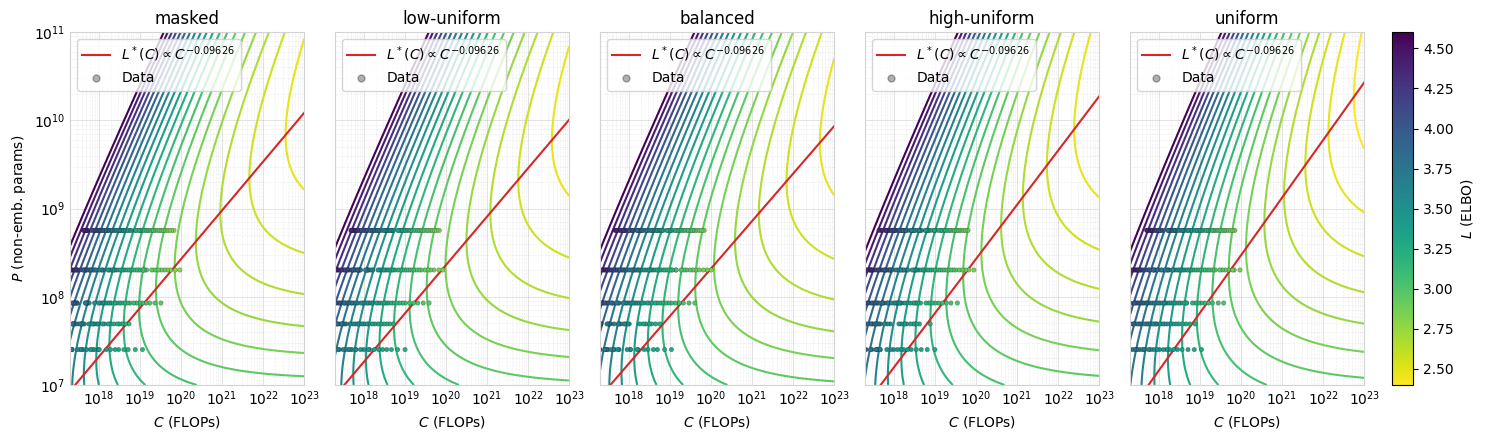

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(14, 4.5), sharex=True, sharey="row")

vmin, vmax = 2.4, 4.6
cmap = "viridis_r"
norm = plt.Normalize(vmin=vmin, vmax=vmax)

flops = np.logspace(17, 23, 100)
params = np.logspace(7, 11, 100)
X, Y = np.meshgrid(flops, params)
tokens = X / (6 * Y)

for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    ax = axs[i]
    a, alpha, b, beta, E = scaling_law["p"]
    loss = E + a * Y**-alpha + b * tokens**-beta

    ax.contour(X, Y, loss, levels=np.logspace(np.log10(vmin), np.log10(vmax), 20), cmap=cmap, norm=norm)

    p_opt = ((alpha*a)/(beta*b))**(1/(alpha+beta)) * (flops/6)**(beta/(alpha+beta))
    expo = beta/(alpha+beta)
    ax.plot(flops, p_opt, linestyle="-", color="C3", label="$L^*(C) \\propto C^{{{:.4g}}}$".format(C_star_alpha))

    dfi = df_.loc[df_["hybrid_mixing_shift"] == hybrid_mixing_shift]
    ps, ts, ls = dfi["non_emb_params"], dfi["tokens"], dfi["target_loss"]
    ax.scatter(6*ps*ts, ps, c=ls, cmap=cmap, norm=norm, edgecolor=(0,0,0,0.3), linewidth=0.5, s=10, zorder=2)
    
    # ax.plot([], [], "-", color=(0.0, 0.0, 0.0, 0.3), label=f"")

    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_title(get_noise_label(hybrid_mixing_shift))
    ax.set_ylim(1e7, 1e11)
    ax.set_xlim(2e17, 1e23)
    if i == 0: ax.set_ylabel("$P$ (non-emb. params)")
    ax.set_xlabel("$C$ (FLOPs)")
    ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
    ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)


    ax.legend(loc="upper left")


for ax in axs.flatten():
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgray')
    ax.tick_params(which="both", length=0, width=0)

fig.tight_layout()

box = axs[-1].get_position()
cax_w, pad = 0.015, 0.02
cax = fig.add_axes([box.x0 + box.width + pad, box.y0, cax_w, box.height])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
fig.colorbar(sm, cax=cax, label="$L$ (ELBO)")
cax.yaxis.set_ticks_position('right'); cax.yaxis.set_label_position('right')

fig.savefig("plots/params_vs_flops.pdf", bbox_inches="tight")


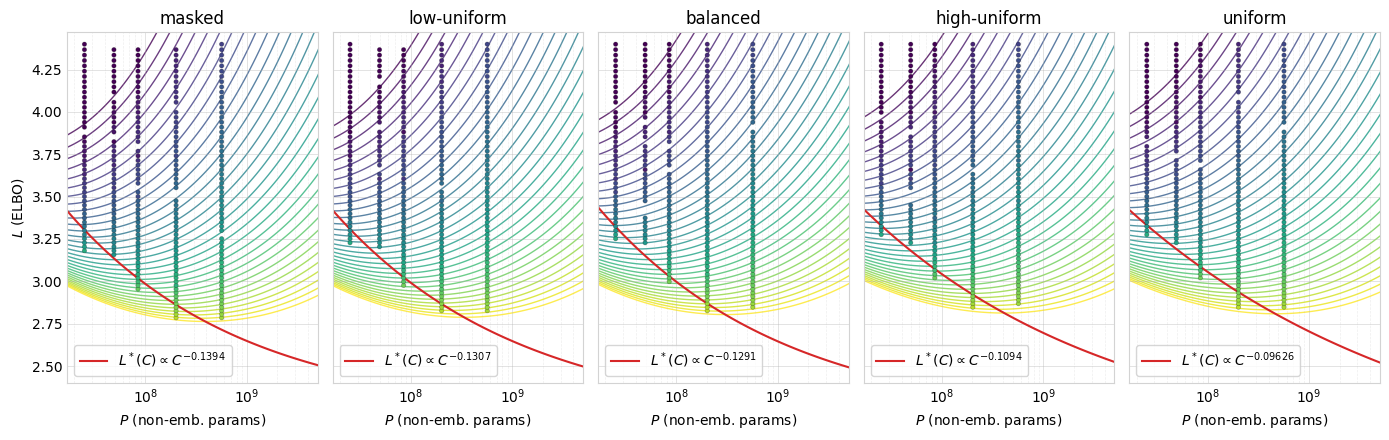

In [119]:
fig, axs = plt.subplots(1, 5, figsize=(14, 4.5), sharex=True, sharey="row")

flop_targets = np.logspace(17, np.log10(2e20), 32)

def color(x):
    cmap = plt.get_cmap("viridis")
    norm = plt.Normalize(vmin=np.log(flop_targets).min(), vmax=np.log(flop_targets).max())
    return cmap(norm(np.log(x)))

for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    ax = axs[i]
    for flops in flop_targets:
        params = np.logspace(7, 10, 100)
        tokens = flops / (6 * params)

        loss = scaling_law["func"](params, tokens, *scaling_law["p"])
        ax.plot(params, loss, color=color(flops), alpha=0.8, zorder=1, linewidth=1.0)

        batch_size = np.logspace(3, 7, 100)
        steps = flops / (6 * params[:, None] * batch_size[None, :])

        # loss = scaling_law["hypothesis3"]["func"](params[:, None], steps, batch_size[None, :], *scaling_law["hypothesis3"]["p"])
        # opt_loss = loss.min(axis=1)

        # opt_idx = loss.argmin()
        # ax.plot(params[opt_idx], loss[opt_idx], ".", color="red")

    dfi = df_.loc[df_["hybrid_mixing_shift"] == hybrid_mixing_shift]
    xs = dfi["non_emb_params"]
    ys = dfi["target_loss"]
    c = dfi["tokens"] * xs * 6
    ax.scatter(xs, ys, c=np.log(c), cmap="viridis", vmin=np.log(flop_targets.min()), vmax=np.log(flop_targets.max()), edgecolor=(0, 0, 0, 0.3), linewidth=0.5, s=10, zorder=3)

    a, alpha, b, beta, E = scaling_law["p"]
    C_star_a = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))
    C_star_alpha = (-(alpha*beta)/(alpha + beta))
    L_star_P = E + a*(alpha + beta)/beta * params**(-alpha)
    # ax.plot(params, L_star_P, linestyle="--", color="blue", label="$L^*(C) = 10^{{{:.4g}}} \\cdot C^{{{:.4g}}} + {:.3f}$".format(np.log10(C_star_a), C_star_alpha, E), zorder=3)
    ax.plot(params, L_star_P, linestyle="-", color="C3", label="$L^*(C) \\propto C^{{{:.4g}}}$".format(C_star_alpha), zorder=2)

    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")
    ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.set_ylim(2.4, 4.47)
    ax.set_xlim(1.7e7, 5e9)
    ax.legend()


    ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5, zorder=0)
    ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2, zorder=0)

for ax in axs.flatten():
    ax.set_xlabel("$P$ (non-emb. params)")
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgray')

    ax.tick_params(which="both", length=0, width=0)

axs[0].set_ylabel("$L$ (ELBO)")

fig.tight_layout()
fig.show()
fig.savefig("plots/scaling_laws.pdf", bbox_inches="tight")

In [136]:
def capitalize(s):
    return s[0].upper() + s[1:]

for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    
    a, alpha, b, beta, E = scaling_law["p"]

    P_star_a = ((a*alpha)/(b*beta))**(1/(alpha + beta))
    D_star_a = ((b*beta)/(a*alpha))**(1/(alpha + beta))
    a_L = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))

    alpha_P = beta / (alpha + beta)
    alpha_D = alpha / (alpha + beta)
    alpha_L = (alpha*beta) / (alpha + beta)

    print(f"{get_noise_label(hybrid_mixing_shift)} & {alpha_P:.3g} & {alpha_D:.3g} & {alpha_L:.3g} & ${E:.3g} + \\frac{{{a:.4g}}}{{P^{{{alpha:.3g}}}}} + \\frac{{{b:.4g}}}{{D^{{{beta:.3g}}}}}$ \\\\")

print("\\midrule")

for label, coeffs in {
    "\\citet{hoffmann2022training}": (1.69, 406.4, 0.34, 410.7, 0.28),
    "\\citet{shuai2024scaling}": (1.48, 314.35, 0.331, 460.51, 0.286),
}.items():
    
    E, a, alpha, b, beta = coeffs

    P_star_a = ((a*alpha)/(b*beta))**(1/(alpha + beta))
    D_star_a = ((b*beta)/(a*alpha))**(1/(alpha + beta))
    a_L = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))

    alpha_P = beta / (alpha + beta)
    alpha_D = alpha / (alpha + beta)
    alpha_L = (alpha*beta) / (alpha + beta)

    print(f"{label} & {alpha_P:.3g} & {alpha_D:.3g} & {alpha_L:.3g} & ${E:.3g} + \\frac{{{a:.4g}}}{{P^{{{alpha:.3g}}}}} + \\frac{{{b:.4g}}}{{D^{{{beta:.3g}}}}}$ \\\\")

masked & 0.554 & 0.446 & 0.139 & $2.22 + \frac{43.79}{P^{0.252}} + \frac{634.2}{D^{0.313}}$ \\
low-uniform & 0.55 & 0.45 & 0.131 & $2.17 + \frac{35.81}{P^{0.238}} + \frac{432.5}{D^{0.291}}$ \\
balanced & 0.539 & 0.461 & 0.129 & $2.17 + \frac{36.82}{P^{0.239}} + \frac{364.8}{D^{0.28}}$ \\
high-uniform & 0.616 & 0.384 & 0.109 & $2.01 + \frac{16.81}{P^{0.178}} + \frac{396.9}{D^{0.285}}$ \\
uniform & 0.654 & 0.346 & 0.0963 & $1.83 + \frac{12.05}{P^{0.147}} + \frac{355}{D^{0.278}}$ \\
\midrule
\citet{hoffmann2022training} & 0.452 & 0.548 & 0.154 & $1.69 + \frac{406.4}{P^{0.34}} + \frac{410.7}{D^{0.28}}$ \\
\citet{shuai2024scaling} & 0.464 & 0.536 & 0.153 & $1.48 + \frac{314.4}{P^{0.331}} + \frac{460.5}{D^{0.286}}$ \\


In [ ]:
# (np.log(x) - np.log(5e8)) / np.log(5e9) = 11/265

np.exp(11/265 * np.log(5e9) + np.log(5e8)) / 1e9

5e8 * 10**(127/265)

1.5073541027501132

(3e+18, 1e+19, 1e+20, 1e+21) (np.float64(101354754.04625562), np.float64(223873152.77488983), np.float64(976252360.0694577), np.float64(4285388112.693726))
AR: P = 0.0001311 C^{0.644}
AR: D = 1272 C^{0.356}
(3e+18, 1e+19, 1e+20, 1e+21) (np.float64(53767248.3390689), np.float64(115665482.1804143), np.float64(497769049.2724412), np.float64(2142160493.7168162))
MDM: P = 0.0001029 C^{0.634}
MDM: D = 1619 C^{0.366}


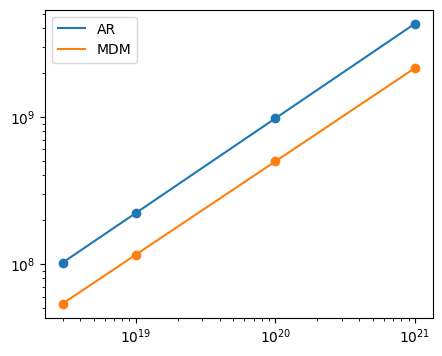

In [1]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

shi_et_al_points = {
    "AR": [(3e18, 1e8), (1.08e20, 1e9), (1e21, 4e9)],
    "MDM": [(3e18, 5.2e7), (1e19, 1.15e8), (1e20, 4e8), (1e21, 2e9)],
}

shi_et_al_points = {
    "AR": [(3e18, 5e7*np.exp(1.75*107/265)), (1e19, 5e7*np.exp(1.75*227/265)), (1e20, 5e7*np.exp(1.75*450/265)), (1e21, 5e7*np.exp(1.75*674/265))],
    "MDM": [(3e18, 5e7*np.exp(1.75*11/265)), (1e19, 5e7*np.exp(1.75*127/265)), (1e20, 5e7*np.exp(1.75*348/265)), (1e21, 5e7*np.exp(1.75*569/265))],
}


for method, points in shi_et_al_points.items():
    flops, params = zip(*tuple(points))
    print(flops, params)
    tokens = np.array(flops) / (6 * np.array(params))

    ax.scatter(flops, params)

    # fit line using polyfit
    coeffs = np.polyfit(np.log(flops), np.log(params), 1)
    b, a = coeffs
    print(f"{method}: P = {np.exp(a):.4g} C^{{{b:.3g}}}")
    xs = np.logspace(np.log10(min(flops)), np.log10(max(flops)), 100)
    ys = np.exp(a) * xs**b
    ax.plot(xs, ys, label=method)


    coeffs = np.polyfit(np.log(flops), np.log(tokens), 1)
    b, a = coeffs
    print(f"{method}: D = {np.exp(a):.4g} C^{{{b:.3g}}}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend();

AR: L = 43.65 C^{-0.06325}
MDM: L = 47.97 C^{-0.06153}


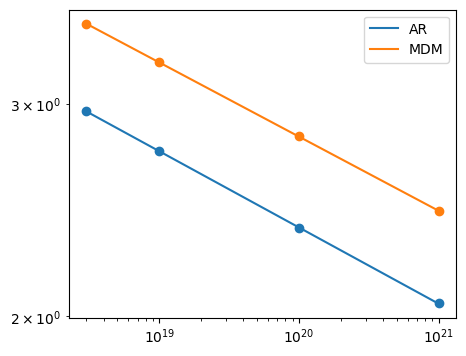

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# shi_et_al_points = {
#     "AR": [(3e18, 2.9), (1e19, 2.75), (1e20, 2.36), (1e21, 2.05)],
#     "MDM": [(3e18, 3.39), (1e19, 3.2), (1e20, 2.86), (1e21, 2.49)],
# }

gamma = 0.403
shi_et_al_points = {
    "AR": [(3e18, 2*np.exp(gamma * 313/322)), (1e19, 2*np.exp(gamma * 253/322)), (1e20, 2*np.exp(gamma * 135/322)), (1e21, 2*np.exp(gamma * 20/322))],
    "MDM": [(3e18, 2*np.exp(gamma * 446/322)), (1e19, 2*np.exp(gamma * 389/322)), (1e20, 2*np.exp(gamma * 275/322)), (1e21, 2*np.exp(gamma * 161/322))],
}

for method, points in shi_et_al_points.items():
    xs, ys = zip(*tuple(points))

    # fit line using polyfit
    coeffs = np.polyfit(np.log(xs), np.log(ys), 1)
    b, a = coeffs
    flops = np.logspace(np.log10(3e18), 21, 100)
    params = np.exp(a) * flops**b
    print(f"{method}: L = {np.exp(a):.4g} C^{{{b:.4g}}}")
    ax.scatter(xs, ys)


    xs = np.logspace(np.log10(min(flops)), np.log10(max(flops)), 100)
    ys = np.exp(a) * xs**b
    ax.plot(xs, ys, label=method)


ax.set_xscale("log")
ax.set_yscale("log")
ax.legend();

In [ ]:
points = ((3e18, 1e8), (1.08e20, 1e9), (1e21, 4e9))
xs, ys = zip(*points)

# fit line using polyfit
coeffs = np.polyfit(np.log(xs), np.log(ys), 1)
b, a = coeffs
flops = np.logspace(18, 23, 100)
params = np.exp(a) * flops**b
a, b

In [18]:
print("1.5b: 200B tokens")
print("7b: 600B tokens")

1.5b: 200B tokens
7b: 600B tokens


In [19]:
df_.groupby(["batch_size"])["lr"].unique()

batch_size
8                 [0.1, 0.2, 0.3]
16           [0.3, 0.2, 0.5, 0.1]
32     [0.5, 0.3, 0.1, 0.2, 0.25]
64           [0.5, 0.3, 1.0, 0.2]
128          [0.5, 0.3, 1.0, 0.4]
256                    [0.5, 1.0]
512               [0.5, 1.0, 2.0]
Name: lr, dtype: object

In [18]:
dfj["batch_size"]

6303     512
6304     512
6305     512
6306     512
6307     512
        ... 
19285      8
19286      8
19287      8
19288      8
19289      8
Name: batch_size, Length: 762, dtype: int64

In [28]:

fit_in_logspace = True

def iso_surface(S, B, L, S_min, S_exp, B_min, B_exp, L_min, L_exp, E):
    S_hat = (S / S_min)**S_exp
    B_hat = (B / B_min)**B_exp
    L_hat = (L / L_min)**L_exp
    return (S_hat - 1)*(B_hat - 1)*(L_hat - 1) * E


print("\\toprule")
for i, (hybrid_mixing_shift, dfi) in enumerate(loss_df.groupby("hybrid_mixing_shift")):
    print(f"{get_noise_label(hybrid_mixing_shift)} & $P$ & $S_\mathrm{{min}}$ & $B_\mathrm{{min}}$ & $L_\mathrm{{min}}$ \\\\")
    for j, (non_emb_params, dfj) in enumerate(dfi.groupby("non_emb_params")):
        dfj = dfj.loc[dfj["batch_size"] < 1024]
        dfj = dfj.loc[dfj.groupby(["batch_size", "target_loss"])["steps"].idxmin()]
        dfj = dfj.loc[(dfj["steps"] <= 100000) & (dfj["steps"] > 5000)]

        S, B, L = dfj["steps"].values, dfj["batch_size"].values, dfj["target_loss"].values

        transform = lambda x: x
        if fit_in_logspace:
            transform = np.log

        def base_resid(f, y, p):
            return transform(f(*p)) - transform(y)

        resid = functools.partial(base_resid, functools.partial(iso_surface, S, B, L), 1.0)
        
        p_0 = (1.0,) * 7
        sol = least_squares(resid, p_0, bounds=(1e-8, np.inf))
        S_min, alpha_S, B_min, alpha_B, L_min, alpha_L, E = sol.x

        print(f"    & {non_emb_params/1e6:.0f}M & {S_min:.3g} & {B_min:.3g} & {L_min:.3g} \\\\")

    print("\\midrule")

print("\\bottomrule")

\toprule
masked & $P$ & $S_\mathrm{min}$ & $B_\mathrm{min}$ & $L_\mathrm{min}$ \\
    & 25M & 1.01e-08 & 2.62e-05 & 1.58 \\


/tmp/ipykernel_2657727/104948375.py:25: RuntimeWarning: invalid value encountered in log
  return transform(f(*p)) - transform(y)


    & 49M & 1.01e-08 & 3.27e-06 & 1.12 \\
    & 85M & 1.01e-08 & 3.78e-07 & 1.28 \\
    & 202M & 1.55e-08 & 0.00101 & 1.5 \\
    & 567M & 1.26e-08 & 8.84e-06 & 0.652 \\
\midrule
low-uniform & $P$ & $S_\mathrm{min}$ & $B_\mathrm{min}$ & $L_\mathrm{min}$ \\
    & 25M & 0.00719 & 1.79e-08 & 1.78 \\
    & 49M & 1.01e-08 & 5.14e-05 & 1.29 \\


    & 85M & 1.31 & 1.41e-08 & 1.88 \\
    & 202M & 0.577 & 2.08e-08 & 1.84 \\
    & 567M & 2.34e-08 & 1.5e-08 & 0.462 \\
\midrule
balanced & $P$ & $S_\mathrm{min}$ & $B_\mathrm{min}$ & $L_\mathrm{min}$ \\
    & 25M & 1e-08 & 4.89e-08 & 1.21 \\
    & 49M & 1.01e-06 & 1e-08 & 0.873 \\
    & 85M & 4.94 & 1.51e-08 & 2.26 \\
    & 202M & 8.2 & 0.000952 & 2.01 \\
    & 567M & 4.36 & 3.68e-08 & 1.51 \\
\midrule
high-uniform & $P$ & $S_\mathrm{min}$ & $B_\mathrm{min}$ & $L_\mathrm{min}$ \\
    & 25M & 1.01e-08 & 7.41e-07 & 1.48 \\
    & 49M & 0.00302 & 1.03e-08 & 1.25 \\
    & 85M & 1.03 & 1e-08 & 1.82 \\
    & 202M & 7.08 & 2.55e-08 & 2.09 \\
    & 567M & 0.342 & 1e-08 & 1.29 \\
\midrule
uniform & $P$ & $S_\mathrm{min}$ & $B_\mathrm{min}$ & $L_\mathrm{min}$ \\
    & 25M & 0.000721 & 1.21e-08 & 1.57 \\
    & 49M & 2.44 & 1.62e-08 & 2.06 \\
    & 85M & 2.17 & 1.99e-08 & 2.22 \\
    & 202M & 8.9 & 1.79e-08 & 2.07 \\
    & 567M & 4.79 & 3.39e-08 & 1.5 \\
\midrule
\bottomrule


In [14]:
scaling_laws = {}
fit_in_logspace = True


def hypothesis1(P, D, a, alpha, b, beta, E):
    return E + a * P**-alpha + b * D**-beta

def hypothesis2(P, S, B, a, alpha, b, beta, S_min, S_exp, B_min, B_exp, E):
    S_hat = (S / S_min)**S_exp
    B_hat = (B / B_min)**B_exp
    return E + a * P**-alpha + b * (1.0 + 1.0 / ((S_hat - 1)*(B_hat - 1)))**-beta

def hypothesis3(P, S, B, L, P_min, P_exp, S_min, S_exp, B_min, B_exp, L_min, L_exp, E):
    P_hat = (P / P_min)**P_exp
    S_hat = (S / S_min)**S_exp
    B_hat = (B / B_min)**B_exp
    L_hat = (L / L_min)**L_exp
    return (P_hat - 1)*(S_hat - 1)*(B_hat - 1)*(L_hat - 1) * E

def hypothesis3a(P, S, B, P_min, P_exp, S_min, S_exp, B_min, B_exp, L_min, L_exp, E):
    P_hat = (P / P_min)**P_exp
    S_hat = (S / S_min)**S_exp
    B_hat = (B / B_min)**B_exp
    return L_min * (1.0 + 1.0 / (E*(P_hat - 1)*(S_hat - 1)*(B_hat - 1)))**(1.0 / L_exp)

for i, (hybrid_mixing_shift, dfi) in enumerate(loss_df.groupby("hybrid_mixing_shift")):
    dfi = dfi
    dfi = dfi.loc[dfi["batch_size"] < 1024]
    dfi1 = dfi.loc[dfi.groupby(["non_emb_params", "target_loss"])["tokens"].idxmin()]
    # dfi1 = dfi.loc[dfi.groupby(["non_emb_params", "tokens"])["target_loss"].idxmin()]
    dfi1 = dfi1.loc[(dfi1["steps"] <= 100000) & (dfi1["steps"] > 5000)]
    dfi2 = dfi.loc[dfi.groupby(["non_emb_params", "batch_size", "target_loss"])["steps"].idxmin()]
    dfi3 = dfi2

    P1, D1, L1 = dfi1["non_emb_params"].values, dfi1["tokens"].values, dfi1["target_loss"].values
    P2, S2, B2, L2 = dfi2["non_emb_params"].values, dfi2["steps"].values, dfi2["batch_size"].values, dfi2["target_loss"].values
    P3, S3, B3, L3 = dfi3["non_emb_params"].values, dfi3["steps"].values, dfi3["batch_size"].values, dfi3["target_loss"].values

    transform = lambda x: x
    if fit_in_logspace:
        transform = np.log

    def base_resid(f, y, p):
        return transform(f(*p)) - transform(y)

    resid1 = functools.partial(base_resid, functools.partial(hypothesis1, P1, D1), L1)
    resid2 = functools.partial(base_resid, functools.partial(hypothesis2, P2, S2, B2), L2)
    resid3 = functools.partial(base_resid, functools.partial(hypothesis3, P3, S3, B3, L3), 1.0)
    resid3a = functools.partial(base_resid, functools.partial(hypothesis3a, P3, S3, B3), L3)
    
    p1_0 = (1.0,) * 5
    p2_0 = (1.0,) * 9
    p3_0 = (1.0,) * 9

    sol1 = least_squares(resid1, p1_0, bounds=(1e-8, np.inf))
    sol2 = least_squares(resid2, p2_0, bounds=(1e-8, np.inf))
    sol3 = least_squares(resid3, p3_0, bounds=(1e-8, np.inf))
    sol3a = least_squares(resid3a, p3_0, bounds=(1e-8, np.inf))

    scaling_laws[hybrid_mixing_shift] = {
        "hypothesis1": {
            "func": hypothesis1,
            "resid": resid1,
            "args": (P1, D1),
            "y": L1,
            "p": sol1.x,
        },
        "hypothesis2": {
            "func": hypothesis2,
            "resid": resid2,
            "args": (P2, S2, B2),
            "y": L2,
            "p": sol2.x,
        },
        "hypothesis3": {
            "func": hypothesis3a,
            "resid": resid3,
            "args": (P3, S3, B3),
            "y": L3,
            "p": sol3.x,
        },
        "hypothesis3a": {
            "func": hypothesis3a,
            "resid": resid3a,
            "args": (P3, S3, B3),
            "y": L3,
            "p": sol3a.x,
        },
    }


/tmp/ipykernel_2657727/1003791513.py:44: RuntimeWarning: invalid value encountered in log
  return transform(f(*p)) - transform(y)


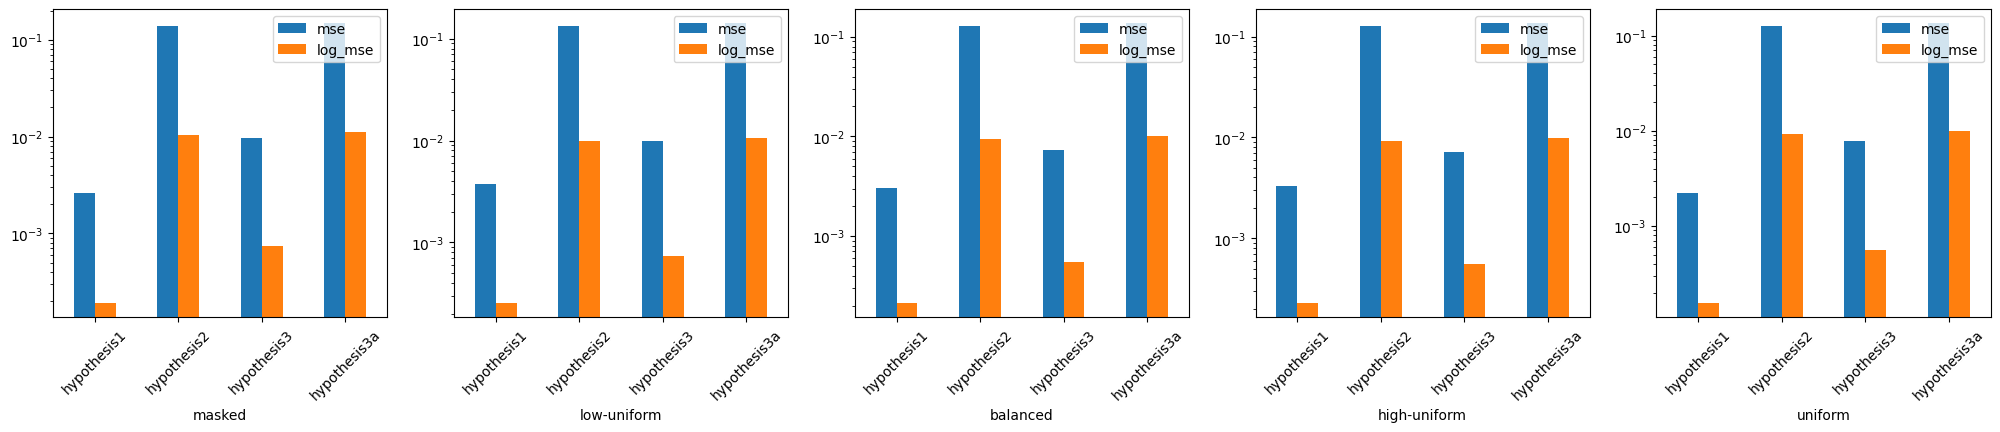

In [15]:
data = []
for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    for hypothesis, item in scaling_law.items():
        L_pred = item["func"](*item["args"], *item["p"])
        mse = np.mean((L_pred - item["y"])**2)
        log_mse = np.mean((np.log(L_pred) - np.log(item["y"]))**2)
        data.append({
            "hybrid_mixing_shift": hybrid_mixing_shift,
            "hypothesis": hypothesis,
            "mse": mse,
            "log_mse": log_mse,
        })

df_ = pd.DataFrame(data)

fig, axs = plt.subplots(1, 5, figsize=(25, 4))

for i, (hybrid_mixing_shift, dfi) in enumerate(df_.groupby("hybrid_mixing_shift")):
    ax = axs[i]
    dfi.drop(columns=["hybrid_mixing_shift"]).plot.bar(x="hypothesis", ax=ax, rot=45)
    ax.set_xlabel(get_noise_label(hybrid_mixing_shift))
    ax.set_yscale("log")

In [22]:
for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    print(f"{get_noise_label(hybrid_mixing_shift)}")
    print("  * hypothesis1: a={:.3g}, alpha={:.3g}, b={:.3g}, beta={:.3g}, E={:.3g}".format(*scaling_law["hypothesis1"]["p"]))
    print("  * hypothesis2: a={:.3g}, alpha={:.3g}, b={:.3g}, beta={:.3g}, S_min={:.3g}, S_exp={:.3g}, B_min={:.3g}, B_exp={:.3g}, E={:.3g}".format(*scaling_law["hypothesis2"]["p"]))
    print("  * hypothesis3: P_min={:.3g}, P_exp={:.3g}, S_min={:.3g}, S_exp={:.3g}, B_min={:.3g}, B_exp={:.3g}, L_min={:.3g}, L_exp={:.3g}, E={:.3g}".format(*scaling_law["hypothesis3"]["p"]))
    print("  * hypothesis3a: P_min={:.3g}, P_exp={:.3g}, S_min={:.3g}, S_exp={:.3g}, B_min={:.3g}, B_exp={:.3g}, L_min={:.3g}, L_exp={:.3g}, E={:.3g}".format(*scaling_law["hypothesis3a"]["p"]))


masked
  * hypothesis1: a=41.6, alpha=0.248, b=654, beta=0.314, E=2.22
  * hypothesis2: a=144, alpha=0.343, b=3.41, beta=0.909, S_min=0.909, S_exp=3.68, B_min=0.906, B_exp=2, E=0.00249
  * hypothesis3: P_min=4.87e-08, P_exp=0.00806, S_min=0.785, S_exp=0.00274, B_min=1.75e-08, B_exp=0.0741, L_min=0.268, L_exp=1.1, E=1.71
  * hypothesis3a: P_min=1, P_exp=1, S_min=1, S_exp=1, B_min=1, B_exp=1, L_min=3.67, L_exp=1, E=1
low-uniform
  * hypothesis1: a=49.3, alpha=0.259, b=464, beta=0.295, E=2.22
  * hypothesis2: a=98.9, alpha=0.318, b=1.86e-06, beta=0.912, S_min=0.912, S_exp=3.68, B_min=0.91, B_exp=2, E=3.42
  * hypothesis3: P_min=1.01e-08, P_exp=0.0125, S_min=0.809, S_exp=0.00328, B_min=0.0001, B_exp=0.0276, L_min=0.151, L_exp=1.12, E=3.48
  * hypothesis3a: P_min=1, P_exp=1.02, S_min=1, S_exp=1, B_min=1, B_exp=1, L_min=3.7, L_exp=1, E=1
balanced
  * hypothesis1: a=47.6, alpha=0.256, b=397, beta=0.285, E=2.21
  * hypothesis2: a=49.3, alpha=0.281, b=0.505, beta=0.76, S_min=0.914, S_exp=3.67, 

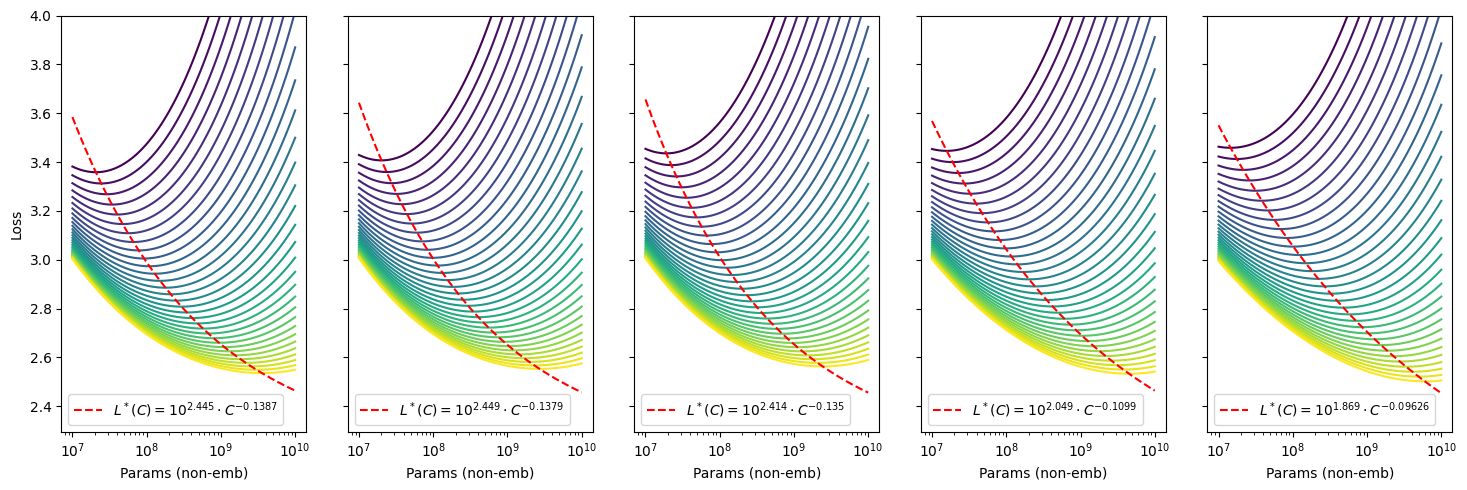

In [23]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5), sharex=False, sharey="row")

flop_targets = np.logspace(18, 22, 32)

def color(x):
    cmap = plt.get_cmap("viridis")
    norm = plt.Normalize(vmin=np.log(flop_targets).min(), vmax=np.log(flop_targets).max())
    return cmap(norm(np.log(x)))

for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    for flops in flop_targets:
        params = np.logspace(7, 10, 100)
        tokens = flops / (6 * params)

        loss = scaling_law["hypothesis1"]["func"](params, tokens, *scaling_law["hypothesis1"]["p"])
        axs[i].plot(params, loss, color=color(flops), alpha=1.0)

        batch_size = np.logspace(3, 7, 100)
        steps = flops / (6 * params[:, None] * batch_size[None, :])

        # loss = scaling_law["hypothesis3"]["func"](params[:, None], steps, batch_size[None, :], *scaling_law["hypothesis3"]["p"])
        # opt_loss = loss.min(axis=1)

        # opt_idx = loss.argmin()
        # axs[i].plot(params[opt_idx], loss[opt_idx], ".", color="red")

    a, alpha, b, beta, E = scaling_law["hypothesis1"]["p"]
    C_star_a = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))
    C_star_alpha = (-(alpha*beta)/(alpha + beta))
    L_star_P = E + a*(alpha + beta)/beta * params**(-alpha)
    axs[i].plot(params, L_star_P, linestyle="--", color="red", label="$L^*(C) = 10^{{{:.4g}}} \\cdot C^{{{:.4g}}}$".format(np.log10(C_star_a), C_star_alpha))

    axs[i].set_xscale("log")
    # axs[i].set_yscale("log")
    axs[i].set_ylim(None, 4)
    axs[i].legend()


for ax in axs.flatten():
    ax.set_xlabel("Params (non-emb)")

axs[0].set_ylabel("Loss")

fig.tight_layout()

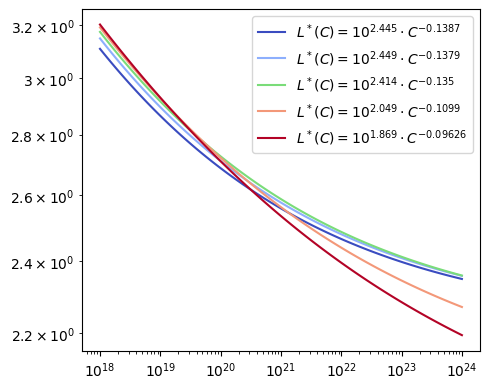

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

flop_targets = np.logspace(18, 22, 32)

def color(x):
    cmap = plt.get_cmap("viridis")
    norm = plt.Normalize(vmin=np.log(flop_targets).min(), vmax=np.log(flop_targets).max())
    return cmap(norm(np.log(x)))

for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    color = colors[hybrid_mixing_shift]

    a, alpha, b, beta, E = scaling_law["hypothesis1"]["p"]
    C_star_a = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))
    C_star_alpha = (-(alpha*beta)/(alpha + beta))

    flops = np.logspace(18, 24, 100)
    L_star_C = E + C_star_a * flops**C_star_alpha
    ax.plot(flops, L_star_C, linestyle="-", color=np.array(color)/255.0, label="$L^*(C) = 10^{{{:.4g}}} \\cdot C^{{{:.4g}}}$".format(np.log10(C_star_a), C_star_alpha))

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()

fig.tight_layout()

masked: P* = 0.0049 * C^{0.559}, D* = 204 * C^{0.441}
low-uniform: P* = 0.0139 * C^{0.532}, D* = 72.2 * C^{0.468}
balanced: P* = 0.0164 * C^{0.526}, D* = 61.1 * C^{0.474}
high-uniform: P* = 0.000422 * C^{0.614}, D* = 2.37e+03 * C^{0.386}
uniform: P* = 7.87e-05 * C^{0.654}, D* = 1.27e+04 * C^{0.346}


Text(0, 0.5, '$D^*$ (tokens)')

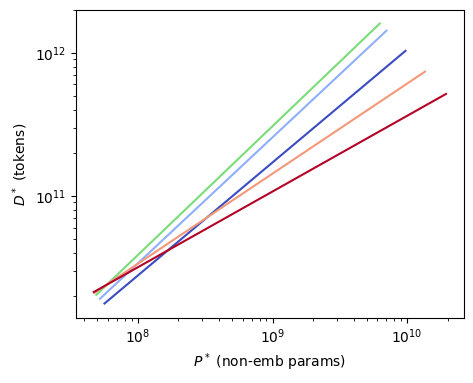

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    color = colors[hybrid_mixing_shift]

    a, alpha, b, beta, E = scaling_law["hypothesis1"]["p"]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    flops = np.logspace(18, 22, 100)
    params = P_star_a * flops**P_star_alpha
    tokens = D_star_a * flops**D_star_alpha

    ax.plot(params, tokens, color=np.array(color)/255.0, label=get_noise_label(hybrid_mixing_shift))


    print(f"{get_noise_label(hybrid_mixing_shift)}: P* = {P_star_a:.3g} * C^{{{P_star_alpha:.3g}}}, D* = {D_star_a:.3g} * C^{{{D_star_alpha:.3g}}}")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("$P^*$ (non-emb params)")
ax.set_ylabel("$D^*$ (tokens)")

MSE: 0.0003587
MSE: 0.0003105
MSE: 0.0003114
MSE: 0.0002899
MSE: 0.0001744


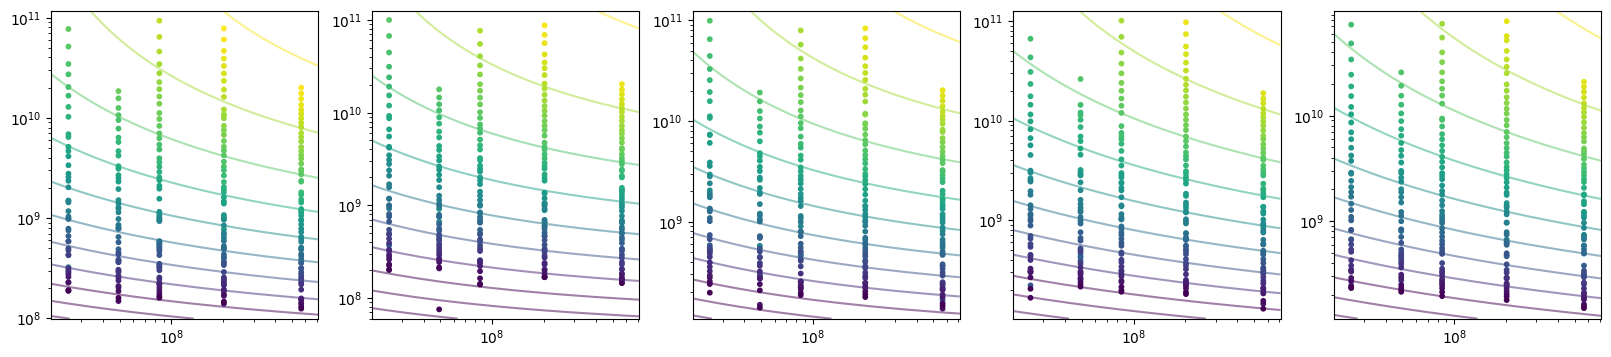

In [26]:
df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "non_emb_params", "target_loss"])["tokens"].idxmin()]

fig, axs = plt.subplots(1, 5, figsize=(20, 4))


vmin, vmax = df_["target_loss"].min(), df_["target_loss"].max()

for i, (hybrid_mixing_shift, dfi) in enumerate(df_.groupby("hybrid_mixing_shift")):
    ax = axs[i]
    x = dfi["non_emb_params"]
    y = dfi["tokens"]
    c = dfi["target_loss"]

    def power_law(x, y, a1, a2, b1, b2, E):
        return E + a1 * x**-a2 + b1 * y**-b2

    def resid(p):
        a1, a2, b1, b2, E = p
        return np.log(power_law(x, y, a1, a2, b1, b2, E)) - np.log(c)

    res = least_squares(resid, x0=[1.0, 0.1, 1.0, 1.0, 1.0], bounds=(1e-8, np.inf))
    a1, a2, b1, b2, E = res.x

    mse = np.mean(resid(res.x)**2)
    print(f"MSE: {mse:.4g}")

    pad = 0.1
    x_hat = np.logspace(np.log10(x.min())-pad, np.log10(x.max())+pad, 100)
    y_hat = np.logspace(np.log10(y.min())-pad, np.log10(y.max())+pad, 100)
    X, Y = np.meshgrid(x_hat, y_hat)
    Z = power_law(X, Y, a1, a2, b1, b2, E)

    ax.contour(X, Y, Z, levels=10, cmap="viridis_r", vmin=vmin, vmax=vmax, alpha=0.5)

    ax.scatter(x, y, c=c, s=10, cmap="viridis_r", vmin=vmin, vmax=vmax)
    ax.set_xscale("log")
    ax.set_yscale("log")

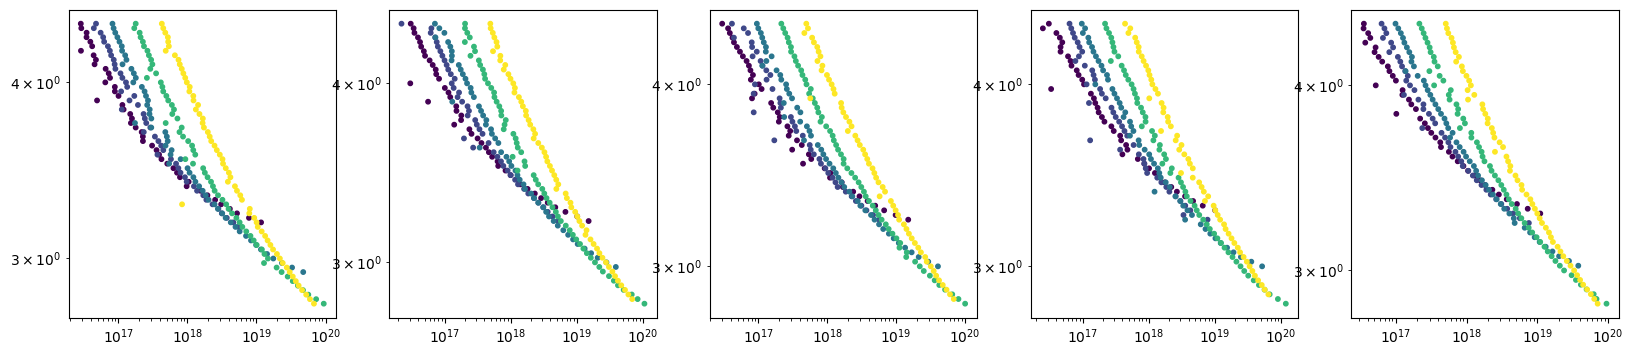

In [27]:
df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "non_emb_params", "target_loss"])["tokens"].idxmin()]

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i, (hybrid_mixing_shift, dfi) in enumerate(df_.groupby("hybrid_mixing_shift")):
    ax = axs[i]
    ps = dfi["non_emb_params"]
    ts = dfi["tokens"]
    ls = dfi["target_loss"]

    flops = 6 * ps * ts
    x = flops
    y = ls


    ax.scatter(x, y, c=np.log(ps), s=10, cmap="viridis")
    ax.set_xscale("log")
    ax.set_yscale("log")

MSE: 0.0003587
MSE: 0.0003105
MSE: 0.0003114
MSE: 0.0002899
MSE: 0.0001744


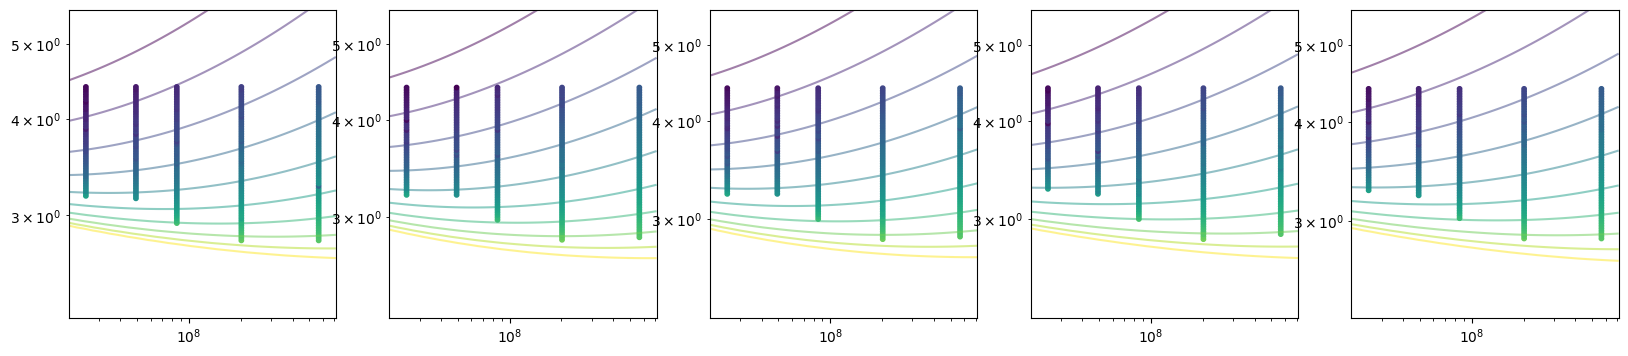

In [28]:
df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "non_emb_params", "target_loss"])["tokens"].idxmin()]

fig, axs = plt.subplots(1, 5, figsize=(20, 4))


flops = 6 * df_["non_emb_params"] * df_["tokens"]
vmin, vmax = flops.min(), 10*flops.max()


def color(x, cmap=plt.get_cmap("viridis")):
    norm = plt.Normalize(vmin=np.log(vmin), vmax=np.log(vmax))
    return cmap(norm(np.log(x)))

for i, (hybrid_mixing_shift, dfi) in enumerate(df_.groupby("hybrid_mixing_shift")):
    ax = axs[i]
    ps = dfi["non_emb_params"]
    ts = dfi["tokens"]
    ls = dfi["target_loss"]
    flops = 6 * ps * ts

    ax.scatter(ps, ls, c=np.log(flops), vmin=np.log(vmin), vmax=np.log(vmax), s=10, cmap="viridis")

    def power_law(x, y, a1, a2, b1, b2, E):
        return E + a1 * x**-a2 + b1 * y**-b2

    def resid(p):
        a1, a2, b1, b2, E = p
        return np.log(power_law(ps, ts, a1, a2, b1, b2, E)) - np.log(ls)

    res = least_squares(resid, x0=[1.0, 1.0, 1.0, 1.0, 1.0], bounds=(1e-8, np.inf))
    a1, a2, b1, b2, E = res.x

    mse = np.mean(resid(res.x)**2)
    print(f"MSE: {mse:.4g}")

    pad = 0.1
    x_hat = np.logspace(np.log10(ps.min())-pad, np.log10(ps.max())+pad, 100)
    y_hat = np.logspace(np.log10(ls.min())-pad, np.log10(ls.max())+pad, 100)
    X, Y = np.meshgrid(x_hat, y_hat)

    with np.errstate(divide='ignore', invalid='ignore'):
        inner = Y - E - a1 * X**-a2
        toks = (b1 / inner)**(1 / b2)
        toks[inner <= 0] = np.nan
        Z = 6 * x_hat * toks

    levels = np.logspace(np.log10(vmin), np.log10(vmax), 10)
    ax.contour(X, Y, np.log(Z), vmin=np.log(vmin), vmax=np.log(vmax), levels=np.log(levels), cmap="viridis", alpha=0.5)

    # for target_flops in np.logspace(np.log10(flops.min()), np.log10(flops.max()), 10):
    #     x_hat = np.logspace(np.log10(ps.min())-0.1, np.log10(ps.max())+0.1, 100)
    #     toks = target_flops / (6 * x_hat)
    #     y_hat = power_law(x_hat, toks, a1, a2, b1, b2, E)

    #     ax.plot(x_hat, y_hat, color=color(target_flops), linestyle="--")


    ax.set_xscale("log")
    ax.set_yscale("log")

Text(0, 0.5, 'Optimal Batch Size')

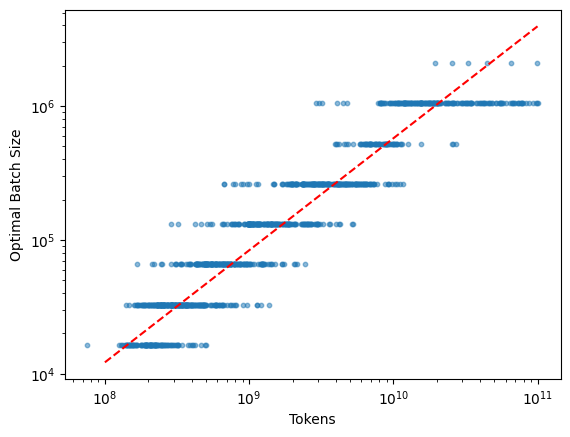

In [29]:
df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "num_layers", "target_loss"])["tokens"].idxmin()]

plt.scatter(df_["tokens"], df_["batch_size"]*2048, alpha=0.5, s=10)

xs = np.logspace(8, 11, 50)
ys = 10**-2.609 * xs**0.8368
plt.plot(xs, ys, "--", label="B*Tokens^0.8368", color="red")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Tokens")
plt.ylabel("Optimal Batch Size")

Text(0, 0.5, 'Batch Size')

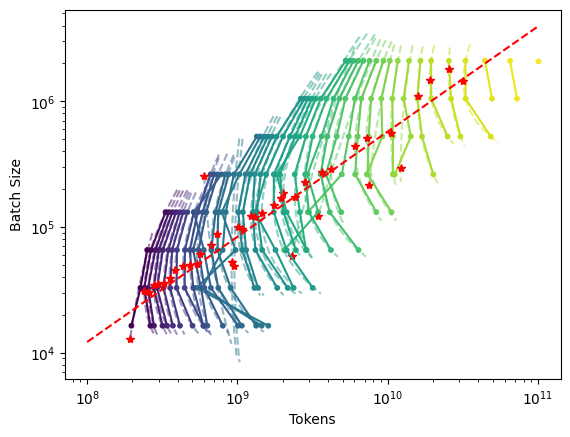

In [30]:
from scipy.optimize import least_squares

# df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "num_layers", "batch_size"])["final_elbo"].idxmin()]
df_ = loss_df
df_ = df_.loc[(df_["hybrid_mixing_shift"] == 0.0) & (df_["num_layers"] == 8)]


vmin = df_["target_loss"].min()
vmax = df_["target_loss"].max()

def color(val, cmap="viridis_r", vmin=vmin, vmax=vmax):
    ratio = (val - vmin) / (vmax - vmin)
    ratio = max(0.0, min(1.0, ratio))
    cmap = plt.get_cmap(cmap)
    return cmap(ratio)

for target_loss, dfi in df_.groupby("target_loss"):
    # dfi = dfi.sort_values("batch_size")
    # dfi = dfi.loc[dfi["steps"] >= 5000]
    idx = dfi.groupby("batch_size")["steps"].idxmin()
    dfi = dfi.loc[idx]
    dfi = dfi.loc[dfi["steps"] >= 2500]
    ys = dfi["batch_size"]*2048
    # xs = dfi["tokens"] / ys
    xs = dfi["steps"]
    # print(target_loss)
    # print(dfi.loc["name"])
    plt.plot(xs*ys, ys, alpha=1.0, color=color(target_loss))
    plt.scatter(xs*ys, ys, c=dfi["target_loss"], alpha=1.0, s=10, cmap="viridis_r", vmin=vmin, vmax=vmax)

    if len(xs) < 3:
        continue

    def resid(p):
        a, b, c = p
        return ((xs / a)**c - 1) * ((ys / b)**c - 1) - 1
    res = least_squares(resid, x0=[1.0, 1.0, 1.0], bounds=(1e-8, np.inf))
    a, b, c = res.x

    x = np.logspace(np.log10(xs.min())-0.1, np.log10(xs.max())+0.1, 100)
    y = b * np.power(((x / a)**c) / (((x / a)**c) - 1.0), 1.0 / c)
    plt.plot(x*y, y, "--", color=color(target_loss), alpha=0.5)
    # print(a, b, c)

    opt_idx = np.argmin(x*y)
    plt.plot(x[opt_idx]*y[opt_idx], y[opt_idx], "*", color="red")


xs = np.logspace(8, 11, 50)
ys = 10**-2.609 * xs**0.8368
plt.plot(xs, ys, "--", label="B*Tokens^0.8368", color="red")

plt.xscale("log")
plt.yscale("log")
# plt.xlim(2000, None)

plt.xlabel("Tokens")
plt.ylabel("Batch Size")

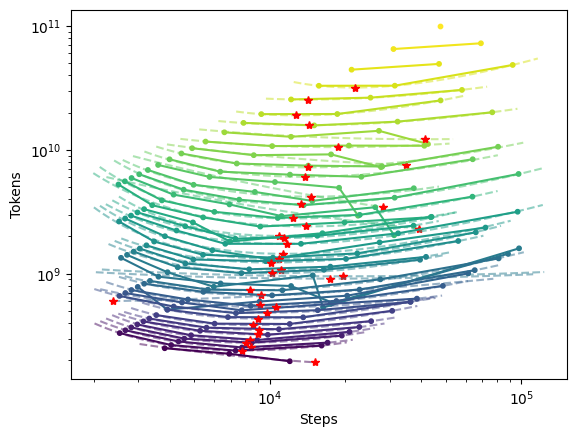

In [31]:
from scipy.optimize import least_squares

# df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "num_layers", "batch_size"])["final_elbo"].idxmin()]
df_ = loss_df
df_ = df_.loc[(df_["hybrid_mixing_shift"] == 0.0) & (df_["num_layers"] == 8)]


def log_power_law(x, a, b, c):
    return np.log(np.exp(a) * x**-b + np.exp(c))

vmin = df_["target_loss"].min()
vmax = df_["target_loss"].max()

def color(val, cmap="viridis_r", vmin=vmin, vmax=vmax):
    ratio = (val - vmin) / (vmax - vmin)
    ratio = max(0.0, min(1.0, ratio))
    cmap = plt.get_cmap(cmap)
    return cmap(ratio)

for target_loss, dfi in df_.groupby("target_loss"):
    # dfi = dfi.sort_values("batch_size")
    # dfi = dfi.loc[dfi["steps"] >= 5000]
    idx = dfi.groupby("batch_size")["steps"].idxmin()
    dfi = dfi.loc[idx]
    dfi = dfi.loc[dfi["steps"] >= 2500]
    ys = dfi["batch_size"]*2048
    # xs = dfi["tokens"] / ys
    xs = dfi["steps"]
    # print(target_loss)
    # print(dfi.loc["name"])
    plt.plot(xs, ys*xs, alpha=1.0, color=color(target_loss))
    plt.scatter(xs, ys*xs, c=dfi["target_loss"], alpha=1.0, s=10, cmap="viridis_r", vmin=vmin, vmax=vmax)

    if len(xs) < 3:
        continue

    def resid(p):
        a, b, c = p
        return ((xs / a)**c - 1) * ((ys / b)**c - 1) - 1
    res = least_squares(resid, x0=[1.0, 1.0, 1.0], bounds=(1e-8, np.inf))
    # popt, _ = curve_fit(log_power_law, xs, np.log(ys), p0=(0.0, 0.1, -1.0), maxfev=100_000)
    # popt, _ = curve_fit(to_solve, np.array([xs, ys]), target, p0=(1.0, 1.0), maxfev=100_000)
    a, b, c = res.x

    x = np.logspace(np.log10(xs.min())-0.1, np.log10(xs.max())+0.1, 100)
    y = b * np.power(((x / a)**c) / (((x / a)**c) - 1.0), 1.0 / c)
    # y_fit = np.exp(log_power_law(x_fit, *popt))
    plt.plot(x, y*x, "--", color=color(target_loss), alpha=0.5)
    # print(a, b, c)

    opt_idx = np.argmin(x*y)
    plt.plot(x[opt_idx], y[opt_idx]*x[opt_idx], "*", color="red")


# xs = np.logspace(8, 11, 50)
# ys = 10**-2.609 * xs**0.8368
# plt.plot(xs, ys, "--", label="B*Tokens^0.8368", color="red")

plt.xscale("log")
plt.yscale("log")
# plt.xlim(2000, None)

plt.xlabel("Steps")
plt.ylabel("Tokens");

Text(0, 0.5, 'Batch Size')

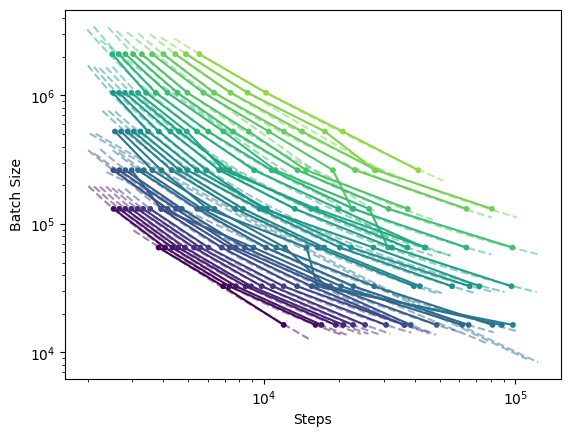

In [32]:
from scipy.optimize import least_squares

# df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "num_layers", "batch_size"])["final_elbo"].idxmin()]
df_ = loss_df
df_ = df_.loc[(df_["hybrid_mixing_shift"] == 0.0) & (df_["num_layers"] == 8)]


def log_power_law(x, a, b, c):
    return np.log(np.exp(a) * x**-b + np.exp(c))

vmin = df_["target_loss"].min()
vmax = df_["target_loss"].max()


ps = []

def color(val, cmap="viridis_r", vmin=vmin, vmax=vmax):
    ratio = (val - vmin) / (vmax - vmin)
    ratio = max(0.0, min(1.0, ratio))
    cmap = plt.get_cmap(cmap)
    return cmap(ratio)

points = []
for target_loss, dfi in df_.groupby("target_loss"):
    if target_loss < 3.4:
        continue
    # dfi = dfi.sort_values("batch_size")
    # dfi = dfi.loc[dfi["steps"] >= 5000]
    idx = dfi.groupby("batch_size")["steps"].idxmin()
    dfi = dfi.loc[idx]
    dfi = dfi.loc[dfi["steps"] >= 2500]
    ys = dfi["batch_size"]*2048
    # xs = dfi["tokens"] / ys
    xs = dfi["steps"]
    # print(target_loss)
    # print(dfi.loc["name"])
    plt.plot(xs, ys, alpha=1.0, color=color(target_loss))
    plt.scatter(xs, ys, c=dfi["target_loss"], alpha=1.0, s=10, cmap="viridis_r", vmin=vmin, vmax=vmax)

    points.extend([{"steps": s, "batch_size": b*2048, "target_loss": target_loss} for s, b in zip(xs, ys)])

    if len(xs) < 3:
        continue

    def resid(p):
        a, b, c = p
        return ((xs / a)**c - 1) * ((ys / b)**c - 1) - 1
    res = least_squares(resid, x0=[1.0, 1.0, 1.0], bounds=(1e-8, np.inf))
    # popt, _ = curve_fit(log_power_law, xs, np.log(ys), p0=(0.0, 0.1, -1.0), maxfev=100_000)
    # popt, _ = curve_fit(to_solve, np.array([xs, ys]), target, p0=(1.0, 1.0), maxfev=100_000)
    a, b, c = res.x
    ps.append({"target_loss": target_loss, "a": a, "b": b, "c": c})

    pad = 0.1
    x = np.logspace(np.log10(xs.min())-pad, np.log10(xs.max())+pad, 100)
    y = b * np.power(((x / a)**c) / (((x / a)**c) - 1.0), 1.0 / c)
    # y_fit = np.exp(log_power_law(x_fit, *popt))
    plt.plot(x, y, "--", color=color(target_loss), alpha=0.5)
    # print(target_loss, [a, b, c])

    # opt_idx = np.argmin(x*y)
    # plt.plot(x[opt_idx]*y[opt_idx], y[opt_idx], "*", color="red")


# xs = np.logspace(8, 11, 50)
# ys = 10**-2.609 * xs**0.8368
# plt.plot(xs, ys, "--", label="B*Tokens^0.8368", color="red")

plt.xscale("log")
plt.yscale("log")
# plt.xlim(2000, None)

plt.xlabel("Steps")
plt.ylabel("Batch Size")

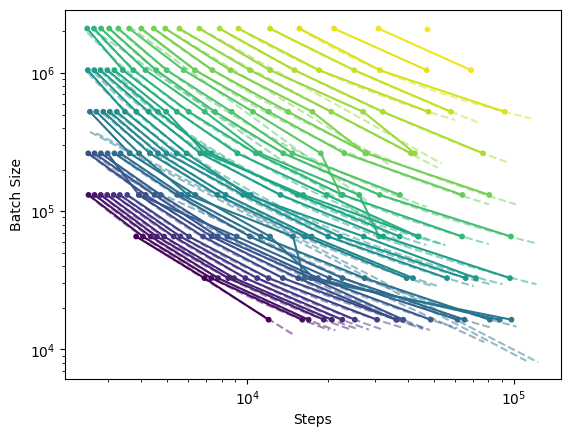

In [33]:
from scipy.optimize import least_squares

# df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "num_layers", "batch_size"])["final_elbo"].idxmin()]
df_ = loss_df
df_ = df_.loc[(df_["hybrid_mixing_shift"] == 0.0) & (df_["num_layers"] == 8)]


def log_power_law(x, a, b, c):
    return np.log(np.exp(a) * x**-b + np.exp(c))

vmin = df_["target_loss"].min()
vmax = df_["target_loss"].max()


ps = []

def color(val, cmap="viridis_r", vmin=vmin, vmax=vmax):
    ratio = (val - vmin) / (vmax - vmin)
    ratio = max(0.0, min(1.0, ratio))
    cmap = plt.get_cmap(cmap)
    return cmap(ratio)

points = []
for target_loss, dfi in df_.groupby("target_loss"):
    # dfi = dfi.sort_values("batch_size")
    # dfi = dfi.loc[dfi["steps"] >= 5000]
    idx = dfi.groupby("batch_size")["steps"].idxmin()
    dfi = dfi.loc[idx]
    dfi = dfi.loc[dfi["steps"] >= 2500]
    ys = dfi["batch_size"]*2048
    # xs = dfi["tokens"] / ys
    xs = dfi["steps"]
    # print(target_loss)
    # print(dfi.loc["name"])
    plt.plot(xs, ys, alpha=1.0, color=color(target_loss))
    plt.scatter(xs, ys, c=dfi["target_loss"], alpha=1.0, s=10, cmap="viridis_r", vmin=vmin, vmax=vmax)

    points.extend([{"steps": s, "batch_size": b*2048, "target_loss": target_loss} for s, b in zip(xs, ys)])

    if len(xs) < 3:
        continue

    def resid(p):
        a, b, c = p
        return a / xs**c + b / ys**c - target_loss
    res = least_squares(resid, x0=[100.0, 100.0, 0.1], bounds=(1e-8, np.inf))
    # popt, _ = curve_fit(log_power_law, xs, np.log(ys), p0=(0.0, 0.1, -1.0), maxfev=100_000)
    # popt, _ = curve_fit(to_solve, np.array([xs, ys]), target, p0=(1.0, 1.0), maxfev=100_000)
    a, b, c = res.x
    ps.append({"target_loss": target_loss, "a": a, "b": b, "c": c})

    pad = 0.1
    x = np.logspace(np.log10(xs.min()), np.log10(xs.max())+pad, 100)
    # y = b * np.power(((x / a)**c) / (((x / a)**c) - 1.0), 1.0 / c)
    y = (b / (target_loss - a / (x**c)))**(1 / c)
    # y_fit = np.exp(log_power_law(x_fit, *popt))
    plt.plot(x, y, "--", color=color(target_loss), alpha=0.5)
    # print(target_loss, [a, b, c])

    # opt_idx = np.argmin(x*y)
    # plt.plot(x[opt_idx]*y[opt_idx], y[opt_idx], "*", color="red")


# xs = np.logspace(8, 11, 50)
# ys = 10**-2.609 * xs**0.8368
# plt.plot(xs, ys, "--", label="B*Tokens^0.8368", color="red")

plt.xscale("log")
plt.yscale("log")
# plt.xlim(2000, None)

plt.xlabel("Steps")
plt.ylabel("Batch Size");

Fitted parameters: [2.93369783e+02 1.42286835e-03 1.39986742e-05 2.50722129e-01
 2.35794810e+00 1.14950741e+00]


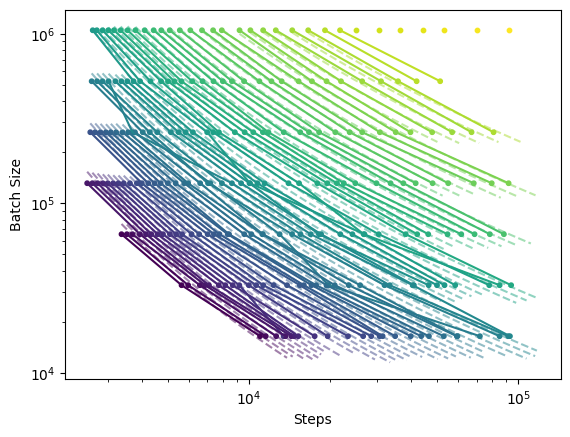

In [34]:
from scipy.optimize import least_squares

# df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "num_layers", "batch_size"])["final_elbo"].idxmin()]
df_ = loss_df
df_ = df_.loc[(df_["hybrid_mixing_shift"] == 2.0) & (df_["num_layers"] == 16)]


def log_power_law(x, a, b, c):
    return np.log(np.exp(a) * x**-b + np.exp(c))

vmin = df_["target_loss"].min()
vmax = df_["target_loss"].max()



dfi = df_.copy()
idx = dfi.groupby(["target_loss", "batch_size"])["steps"].idxmin()
dfi = dfi.loc[idx]
xs = dfi["steps"].to_numpy()
ys = (dfi["batch_size"]*2048).to_numpy()
losses = dfi["target_loss"].to_numpy()

def resid(p):
    a1, a2, b1, b2, c1, c2 = p
    return ((xs/a1)**a2  - 1) * ((ys/b1)**b2 - 1) * ((losses/c1)**c2 - 1) - 1

res = least_squares(resid, x0=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bounds=(1e-8, np.inf), loss="linear")
a1, a2, b1, b2, c1, c2 = res.x

print("Fitted parameters:", res.x)

ps = []

def color(val, cmap="viridis_r", vmin=vmin, vmax=vmax):
    ratio = (val - vmin) / (vmax - vmin)
    ratio = max(0.0, min(1.0, ratio))
    cmap = plt.get_cmap(cmap)
    return cmap(ratio)

points = []
for target_loss, dfi in df_.groupby("target_loss"):
    # dfi = dfi.sort_values("batch_size")
    # dfi = dfi.loc[dfi["steps"] >= 5000]
    idx = dfi.groupby("batch_size")["steps"].idxmin()
    dfi = dfi.loc[idx]
    dfi = dfi.loc[dfi["steps"] >= 2500]
    ys = dfi["batch_size"]*2048
    # xs = dfi["tokens"] / ys
    xs = dfi["steps"]
    # print(target_loss)
    # print(dfi.loc["name"])
    plt.plot(xs, ys, alpha=1.0, color=color(target_loss))
    plt.scatter(xs, ys, c=dfi["target_loss"], alpha=1.0, s=10, cmap="viridis_r", vmin=vmin, vmax=vmax)

    points.extend([{"steps": s, "batch_size": b*2048, "target_loss": target_loss} for s, b in zip(xs, ys)])

    if len(xs) < 3:
        continue

    pad = 0.1
    x = np.logspace(np.log10(xs.min()), np.log10(xs.max())+pad, 100)
    with np.errstate(divide="ignore", invalid="ignore"):
        X = (x / a1) ** a2 - 1.0
        L = (target_loss / c1) ** c2 - 1.0
        Y = 1.0 + 1.0 / (X * L)
        y = b1 * Y**(1.0 / b2)
        y = np.where(np.isfinite(y) & (Y > 0), y, np.nan)
    plt.plot(x, y, "--", color=color(target_loss), alpha=0.5)
    # print(target_loss, [a, b, c])

    # opt_idx = np.argmin(x*y)
    # plt.plot(x[opt_idx]*y[opt_idx], y[opt_idx], "*", color="red")


# xs = np.logspace(8, 11, 50)
# ys = 10**-2.609 * xs**0.8368
# plt.plot(xs, ys, "--", label="B*Tokens^0.8368", color="red")

plt.xscale("log")
plt.yscale("log")
# plt.xlim(2000, None)

plt.xlabel("Steps")
plt.ylabel("Batch Size");